# To-do list:


In [19]:
"""Friday May 31 - DONE"""

# [done] change: maybe take 36 samples or more samples
# [done] change: model restructure


"""Sat June 1st"""
# [solved] warning: GradCAM behavior is weird, look at the heatmap and truth vs. predicted
# - solve by: build deeper model, use last layer of convo. for gradCAM
# - cuz in the current 2 layer convo , the last convo might not see a lot
# [done] Do Data augmentation


# [done ]Restructure dataset and get_dataloader so that we can get train_dataloader(with transform and augmentation),
# - val_dataloader with transform only,
# - test_dataloader with transform only
## But we really just need to have train_dataloader that has augmentation because the only transform we'll use
## is ToTensor() which converts to [0, 1] which slows down training and leads to worse results

"""Sun June 2st"""
# [] Make the model_v1 more complex

# [not gonna do it] restructure the code to different .py
# [done] use Lightning
# [done] transfer learning -> need to add 'transform' in custom dataset

"""Mon June 3rd"""
# [done] Transfer learning with two or three models
# [done] Do Early STopping
# [not gonna] lightning confusion matrix
# [done] try RichProgressBar

# [] train longer
# [done] WeightedRandomSampler
# [done] functionalize the GradCAM

'Mon June 3rd'

# imports


In [20]:
%matplotlib inline

import os
import time
import random
from timeit import default_timer as timer

import numpy as np
import pandas as pd

import lightning as L
from lightning.pytorch.loggers import CSVLogger
# from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import ModelSummary
from lightning.pytorch.utilities.model_summary import ModelSummary as m_summary

from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import RichProgressBar


# Deep Learning Libraries
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torchinfo import summary

# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator

# Additional Libraries
from PIL import Image
from torchinfo import summary
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
)

from watermark import watermark

from sklearn.model_selection import train_test_split
import seaborn as sns

from pytorch_grad_cam import (
    GradCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
)
from pytorch_grad_cam.utils.image import (
    show_cam_on_image,
    deprocess_image,
    preprocess_image,
)

from timeit import default_timer as timer

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import cv2

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [21]:
# helper_config

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

RANDOM_SEED = 123
IMG_SIZE = 20
BATCH_SIZE = 64
TEST_SIZE = 0.2

NUM_EPOCHS = 46
LEARNING_RATE = 0.05

In [22]:
# help_utils


def get_confusion_matrix(y_true, y_pred) -> None:

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="viridis").ax_.set_title("Confusion Matrix")
    plt.show()


def print_input_output_shapes(model: torch.nn.Module) -> None:

    print(f"=== Model: {model.__class__.__name__} ===")
    sample_input = torch.rand((1, 3, 20, 20))
    print(f"Sample input shape: {sample_input.shape}")
    print(f"Sample input:\n{sample_input}")

    print()
    sample_output = model(sample_input)

    print(f"- Sample output:", sample_output)
    print(f"- Sample output dtype: {sample_output.dtype}")
    print(f"- Model output shape: {sample_output.shape}")


def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Training time on {device}: {total_time:.3f} seconds")
    return total_time


def save_model(model: torch.nn.Module, batch_size, num_epochs, learning_rate):
    """Saves a PyTorch model to a target directory.

    Args:
      model: A target PyTorch model to save.
      target_dir: A directory for saving the model to.
      model_name: A filename for the saved model. Should include
        either ".pth" or ".pt" as the file extension.

    Example usage:
      save_model(model=model_0,
                 target_dir="models",
                 model_name="05_going_modular_tingvgg_model.pth")
    """

    model_name = (
        f"{model.__class__.__name__}_{batch_size}_{num_epochs}_{learning_rate}.pth"
    )
    model_save_path = "model_weights" + "/" + model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)


def evaluate_naive_model(
    dataloader: torch.utils.data.DataLoader,
):

    y_true_labels = []
    naive_predictions = []

    for images, labels in dataloader:
        all_zeros = torch.zeros_like(labels)
        y_true_labels.extend(labels.cpu().numpy())
        naive_predictions.extend(all_zeros.numpy())

    ### classification_report
    target_names = ["No Plane", "Plane"]
    print(
        classification_report(
            y_true=y_true_labels,
            y_pred=naive_predictions,
            target_names=target_names,
            zero_division=0.0,
        )
    )

    cm = confusion_matrix(y_true=y_true_labels, y_pred=naive_predictions)
    ConfusionMatrixDisplay(cm).plot(cmap="viridis").ax_.set_title(
        "NaiveModel: Confusion Matrix"
    )
    plt.show()

# Device


In [23]:
device

'mps'

# 1. Loading and Visualizing the dataset


In [24]:
dirname = "planesnet/planesnet"

class_planes = []
class_no_planes = []

for filename in os.listdir(dirname):

    if filename.startswith("1"):
        class_planes.append(filename)
    elif filename.startswith("0"):
        class_no_planes.append(filename)

print(len(class_planes), len(class_no_planes))

8000 24000


## bar chart


In [25]:
# helper_plotting


def plot_and_save_data_distr_bar_char(class_planes: list, class_no_planes: list):

    # Extract data for the bar chart
    data = [len(class_planes), len(class_no_planes)]  # Number of images in each class
    class_labels = ["Planes", "No Planes"]  # Class labels

    plt.figure(figsize=(8, 8), dpi=300)
    # Create a bar chart with Seaborn
    ax = sns.barplot(x=class_labels, y=data)

    # Add data labels on top of bars
    for bar in ax.containers[0]:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 3,
            str(int(height)),
            ha="center",
            va="bottom",
            fontsize=12,
        )  # Adjust formatting

    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.title("Distribution of Images in Planesnet Dataset", fontsize=15)
    plt.xticks(rotation=0)

    plt.savefig("plots/ditribution_of_dataset.png", dpi=300)

    # Display the chart
    plt.tight_layout()
    plt.show()


def plot_and_save_pie_chart(data, class_labels):

    # Calculate total images and percentages
    total_images = sum(data)
    percentages = [value / total_images * 100 for value in data]

    # Create a pie chart with Matplotlib (within Seaborn context)
    plt.figure(figsize=(8, 8), dpi=300)
    pie_chart = plt.pie(
        x=percentages, labels=class_labels, autopct="%1.1f%%", startangle=140
    )

    # Customize the chart title (optional)
    plt.title("Distribution of Images in Planesnet Dataset (Percentage)", fontsize=15)

    # Save the figure
    plt.savefig("plots/class_distribution_pie.png", dpi=200, transparent=False)

    # Optional: Display the chart
    plt.tight_layout()
    plt.show()


def plot_minibatch_loss_curve(
    batch_size: int,
    num_epochs: int,
    lr: float,
    log_dict: dict,
    averaging_iterations=100,
):
    """Plots Training vs. Validation minibatch loss curves"""

    model_details = f"model: {log_dict['model_name']}, batch_size: {batch_size}, num_epochs: {num_epochs}, lr: {lr}"
    main_title = "Training vs. Validation Loss Per mini batches"

    # Calculate the number of iterations per epoch
    iter_per_epoch = len(log_dict["train_loss_per_batch"]) // num_epochs

    plt.figure(figsize=(10, 8))
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(log_dict["train_loss_per_batch"], label="Training loss")
    ax1.plot(log_dict["val_loss_per_batch"], label="Validation loss")

    plt.xlabel(
        f"Num of mini-batches (Total: {len(log_dict['train_loss_per_batch'])})",
        fontsize=12,
    )
    plt.ylabel("Loss", fontsize=12)
    plt.suptitle(main_title, fontsize=15)
    plt.title(model_details, fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)

    # Determine the range for y-axis
    if len(log_dict["train_loss_per_batch"]) < 800:
        num_losses = len(log_dict["train_loss_per_batch"]) // 2
    else:
        num_losses = 800

    max_train_loss = np.max(log_dict["train_loss_per_batch"][num_losses:])
    max_val_loss = np.max(log_dict["val_loss_per_batch"][num_losses:])
    max_loss = max(max_train_loss, max_val_loss)

    # if len(log_dict["val_loss_per_batch"]) >= num_losses:

    #     max_train_loss = np.max(log_dict["train_loss_per_batch"][num_losses:])
    #     max_val_loss = np.max(log_dict["val_loss_per_batch"][num_losses:])
    #     max_loss = max(max_train_loss, max_val_loss)
    # else:
    #     max_train_loss = np.max(log_dict["train_loss_per_batch"][num_losses:])
    #     max_val_loss = np.max(log_dict["val_loss_per_batch"][num_losses:])
    #     max_loss = max(max_train_loss, max_val_loss)

    ax1.set_ylim([0, max_loss * 1.5])

    # Smooth the loss curves
    kernel = np.ones(averaging_iterations) / averaging_iterations
    smoothed_train_loss = np.convolve(
        log_dict["train_loss_per_batch"], kernel, mode="valid"
    )
    smoothed_val_loss = np.convolve(
        log_dict["val_loss_per_batch"], kernel, mode="valid"
    )

    ax1.plot(smoothed_train_loss, label="Running Average Training loss")
    ax1.plot(smoothed_val_loss, label="Running Average Validation loss")

    ax1.legend()

    ###################
    # Set second x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs + 1))
    newpos = [e * iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("outward", 45))
    ax2.set_xlabel("Epochs")
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()
    plt.savefig(
        f"plots/minibatch_train_val_loss_{batch_size}_{num_epochs}_{lr}.png",
        transparent=False,
        dpi=300,
    )
    plt.show()


def plot_epoch_loss_curve(batch_size: int, num_epochs: int, lr: float, log_dict: dict):

    model_details = f"model: {log_dict['model_name']}, batch_size: {batch_size}, num_epochs: {num_epochs}, lr: {lr}"
    main_title = "Training vs Validation Loss per epoch"

    plt.figure(figsize=(10, 8))
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(log_dict["train_loss_per_epoch"], label="Training loss")

    # Highlight the last epoch loss with a marker and slightly higher alpha
    last_train_epoch_loss = log_dict["train_loss_per_epoch"][-1]
    ax1.scatter(
        len(log_dict["train_loss_per_epoch"]) - 1,
        last_train_epoch_loss,
        marker="o",
        c="red",
        alpha=0.8,
        label=f"Last Training Epoch Loss: {last_train_epoch_loss:.4f}",
    )

    ax1.plot(log_dict["val_loss_per_epoch"], label="Validation loss", c="green")
    last_val_epoch_loss = log_dict["val_loss_per_epoch"][-1]
    ax1.scatter(
        len(log_dict["val_loss_per_epoch"]) - 1,
        last_val_epoch_loss,
        marker="o",
        c="green",
        alpha=0.8,
        label=f"Last Validation Epoch Loss: {last_val_epoch_loss:.4f}",
    )

    plt.xlabel(f"Num of epochs: {len(log_dict['train_loss_per_epoch'])}", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.suptitle(main_title, fontsize=15)
    plt.title(model_details, fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)

    # # Determine the range for y-axis
    # max_train_loss = np.max(log_dict["train_loss_per_epoch"])
    # max_val_loss = np.max(log_dict["val_loss_per_epoch"])
    # max_loss = max(max_train_loss, max_val_loss)
    # ax1.set_ylim([0, max_loss * 1.5])

    plt.tight_layout()
    plt.savefig(
        f"plots/epoch_train_val_loss_{batch_size}_{num_epochs}_{lr}.png",
        transparent=False,
        dpi=300,
    )
    plt.show()


def get_confusion_matrix(y_true, y_pred) -> None:

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="viridis").ax_.set_title("Confusion Matrix")
    plt.show()


def plot_test_loss_per_batch(
    test_loss_per_batch: list,
    batch_size,
    lr,
    num_epochs,
):

    title = f"Testing loss per batch\n batch_size:{batch_size}, lr:{lr}"

    plt.figure(figsize=(8, 8))
    plt.plot(test_loss_per_batch, label="Testing loss")

    last_batch_loss = test_loss_per_batch[-1]
    plt.scatter(
        len(test_loss_per_batch) - 1,
        last_batch_loss,
        marker="o",
        c="red",
        alpha=0.8,
        label=f"Last minibatch loss: {last_batch_loss:.4f}",
    )

    plt.xlabel(f"Num of mini-batches (Total: {len(test_loss_per_batch)})")
    plt.ylabel(f"Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(
        f"plots/epoch_test_loss_{batch_size}_{num_epochs}_{lr}.png",
        transparent=False,
    )
    plt.show()


def set_random_seed(seed_value=42):
    """Sets the random seed for reproducibility"""
    random.seed(seed_value)
    torch.manual_seed(seed_value)


def collect_samples_to_predict(
    dataloader: torch.utils.data.DataLoader, num_samples=36
) -> tuple[list, torch.Tensor]:
    """Collects a specified number of random samples and labels from the DataLoader.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader to collect samples from.
        num_samples (int, optional): The desired number of samples to collect. Defaults to 36.

    Returns:
        tuple[list, torch.Tensor]: A tuple containing a list of collected samples and a tensor of corresponding ground truth labels.
    """

    test_samples = []
    test_labels = []

    for samples, labels in dataloader:
        # select 16  # change: maybe take 36 samples or more samples
        if len(test_samples) >= num_samples:
            break

        # generate a random index
        n = random.randint(0, samples.shape[0] - 1)
        test_samples.append(samples[n])  # 1 observation
        test_labels.append(labels[n])  # 1 observation

        ground_truth = torch.tensor(test_labels)

    return test_samples, ground_truth


def make_predictions(
    model: torch.nn.Module, test_samples: list, device: torch.device
) -> torch.Tensor:
    """Makes predictions on a list of samples using the model.

    Args:
        model (torch.nn.Module): The model to use for predictions.
        test_samples (list): A list of samples to make predictions on.
        device (torch.device): The device to use for computations (e.g., CPU or GPU).

    Returns:
        torch.Tensor: A tensor containing the predicted labels for the samples.
    """

    pred_labels_list = []

    model.eval()
    with torch.inference_mode():
        for sample in test_samples:
            pred_logits = model(sample.to(device).unsqueeze(dim=0))
            # y_probs = torch.softmax(y_logits, dim=1)
            pred_labels = torch.softmax(pred_logits, dim=1).argmax(dim=1)
            pred_labels_list.append(pred_labels.float().cpu())
            predictions = torch.stack(pred_labels_list)

    return predictions.squeeze()


def plotting(test_samples, predictions, ground_truth, model) -> None:
    """Creates a plot visualizing predictions vs. ground truth labels.

    Args:
        test_samples (list): A list of test samples (images).
        predictions (torch.Tensor): A tensor containing the predicted labels.
        ground_truth (torch.Tensor): A tensor containing the ground truth labels.
    """

    model_name = model.__class__.__name__

    plt.figure(figsize=(13, 13), dpi=300)

    nrows, ncols = 6, 6

    for i, sample in enumerate(test_samples):

        plt.subplot(nrows, ncols, i + 1)
        plt.imshow((sample / 255.0).permute(1, 2, 0))

        pred_label = "Plane" if predictions[i] == 1.0 else "No Plane"
        truth_label = "Plane" if ground_truth[i] == 1.0 else "No Plane"

        if pred_label == truth_label:
            truth_label = "*Plane*" if truth_label == "Plane" else "No Plane"
            title_text = f"Pred: {pred_label} | Truth: {truth_label}"
            plt.title(title_text, fontsize=8, c="g")  # green text if correct
        else:
            truth_label = "*Plane*" if truth_label == "Plane" else "No Plane"
            title_text = f"Pred: {pred_label} | Truth: {truth_label}"
            plt.title(title_text, fontsize=8, c="r")  # red text if incorrect

        plt.axis("off")

    plt.suptitle("Predictions vs. Truths", fontsize=15)
    plt.tight_layout()
    plt.savefig(f"pred_vs_truth_plots/{model_name}.png", transparent=False, dpi=300)
    plt.show()


def plot_pred_vs_truth(
    sample_dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    device: torch.device,
    num_samples: int = 36,
    set_random: bool = True,
):
    """Plots predictions vs. true labels"""

    if set_random:
        set_random_seed()

    test_samples, ground_truth = collect_samples_to_predict(
        sample_dataloader, num_samples=num_samples
    )
    predictions = make_predictions(
        model=model, test_samples=test_samples, device=device
    )

    plotting(test_samples, predictions, ground_truth, model)


### DONE BELOW ###
def visualize_dataloader(
    dataloader, balanced: bool, collect_n_batches: int, batch_size: int
) -> None:
    """Visualizes the data ditribution in the dataloader"""

    dataset_type = "Balanced" if balanced else "Imbalanced"

    class_0_batch_counts = []
    class_1_batch_counts = []

    for i, (_, labels) in enumerate(dataloader):
        if i < collect_n_batches:
            batch_labels = labels.tolist()
            class_0_count = batch_labels.count(0)
            class_1_count = batch_labels.count(1)
            class_0_batch_counts.append(class_0_count)
            class_1_batch_counts.append(class_1_count)

    fig, ax = plt.subplots(1, figsize=(15, 10), dpi=300)
    plt.suptitle(f"Class Distribution Across Batches", fontsize=15)

    ind = np.arange(len(class_0_batch_counts))
    width = 0.35

    ax.bar(ind, class_0_batch_counts, width, label="0: No Planes")
    ax.bar(ind + width, class_1_batch_counts, width, label="1: Planes")
    ax.set_xticks(ind, ind + 1)
    ax.set_xlabel("Batch index", fontsize=12)
    ax.set_ylabel("No. of images in batch", fontsize=12)
    ax.yaxis.set_major_locator(
        MaxNLocator(integer=True)
    )  # Set integer ticks for y-axis

    ax.set_aspect("equal")
    plt.legend()
    ax.grid(color="lightgray", linestyle="-", linewidth=0.5, alpha=0.7)
    plt.subplots_adjust(top=0.88)
    plt.title(f"({dataset_type} Dataset) | Batch size: {batch_size}", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"balanced_imbalanced_dataset_plots/{dataset_type}.png")

    plt.show()


def plot_loss_and_acc(log_dir) -> None:

    import pandas as pd
    import matplotlib.pyplot as plt

    plt.rcParams["figure.figsize"] = [10, 8]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["figure.dpi"] = 300

    metrics = pd.read_csv(f"{log_dir}/metrics.csv")
    # Group metrics by epoch and calculate mean for each metric
    df_metrics = metrics.groupby("epoch").mean()

    num_epochs = len(df_metrics)

    # Add epoch as a column
    df_metrics["epoch"] = df_metrics.index  # Index is the grouping key (epoch)

    print(df_metrics.head(10))

    last_train_epoch_loss = (
        df_metrics[["train_loss_epoch", "val_loss_epoch"]].iloc[-1, :].iloc[0]
    )
    last_val_epoch_loss = (
        df_metrics[["train_loss_epoch", "val_loss_epoch"]].iloc[-1, :].iloc[-1]
    )

    df_metrics[["train_loss_epoch", "val_loss_epoch"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )

    plt.suptitle("Training and Validation Loss per Epoch", fontsize=15)
    plt.title(
        f"{num_epochs}/{helper_config.NUM_EPOCHS} Epochs | Batch Size: {helper_config.BATCH_SIZE} | LR: {helper_config.LEARNING_RATE}",
        fontsize=12,
    )

    plt.scatter(
        len(df_metrics[["train_loss_epoch", "val_loss_epoch"]]) - 1,
        last_train_epoch_loss,
        marker="o",
        c="red",
        alpha=0.8,
        label=f"Last Training Epoch Loss: {last_train_epoch_loss:.4f}",
    )

    plt.scatter(
        len(df_metrics[["train_loss_epoch", "val_loss_epoch"]]) - 1,
        last_val_epoch_loss,
        marker="o",
        c="green",
        alpha=0.8,
        label=f"Last Validation Epoch Loss: {last_val_epoch_loss:.4f}",
    )
    plt.legend()

    plt.savefig(f"{log_dir}/loss_curve.png", dpi=300, bbox_inches="tight")
    plt.show()

/opt/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


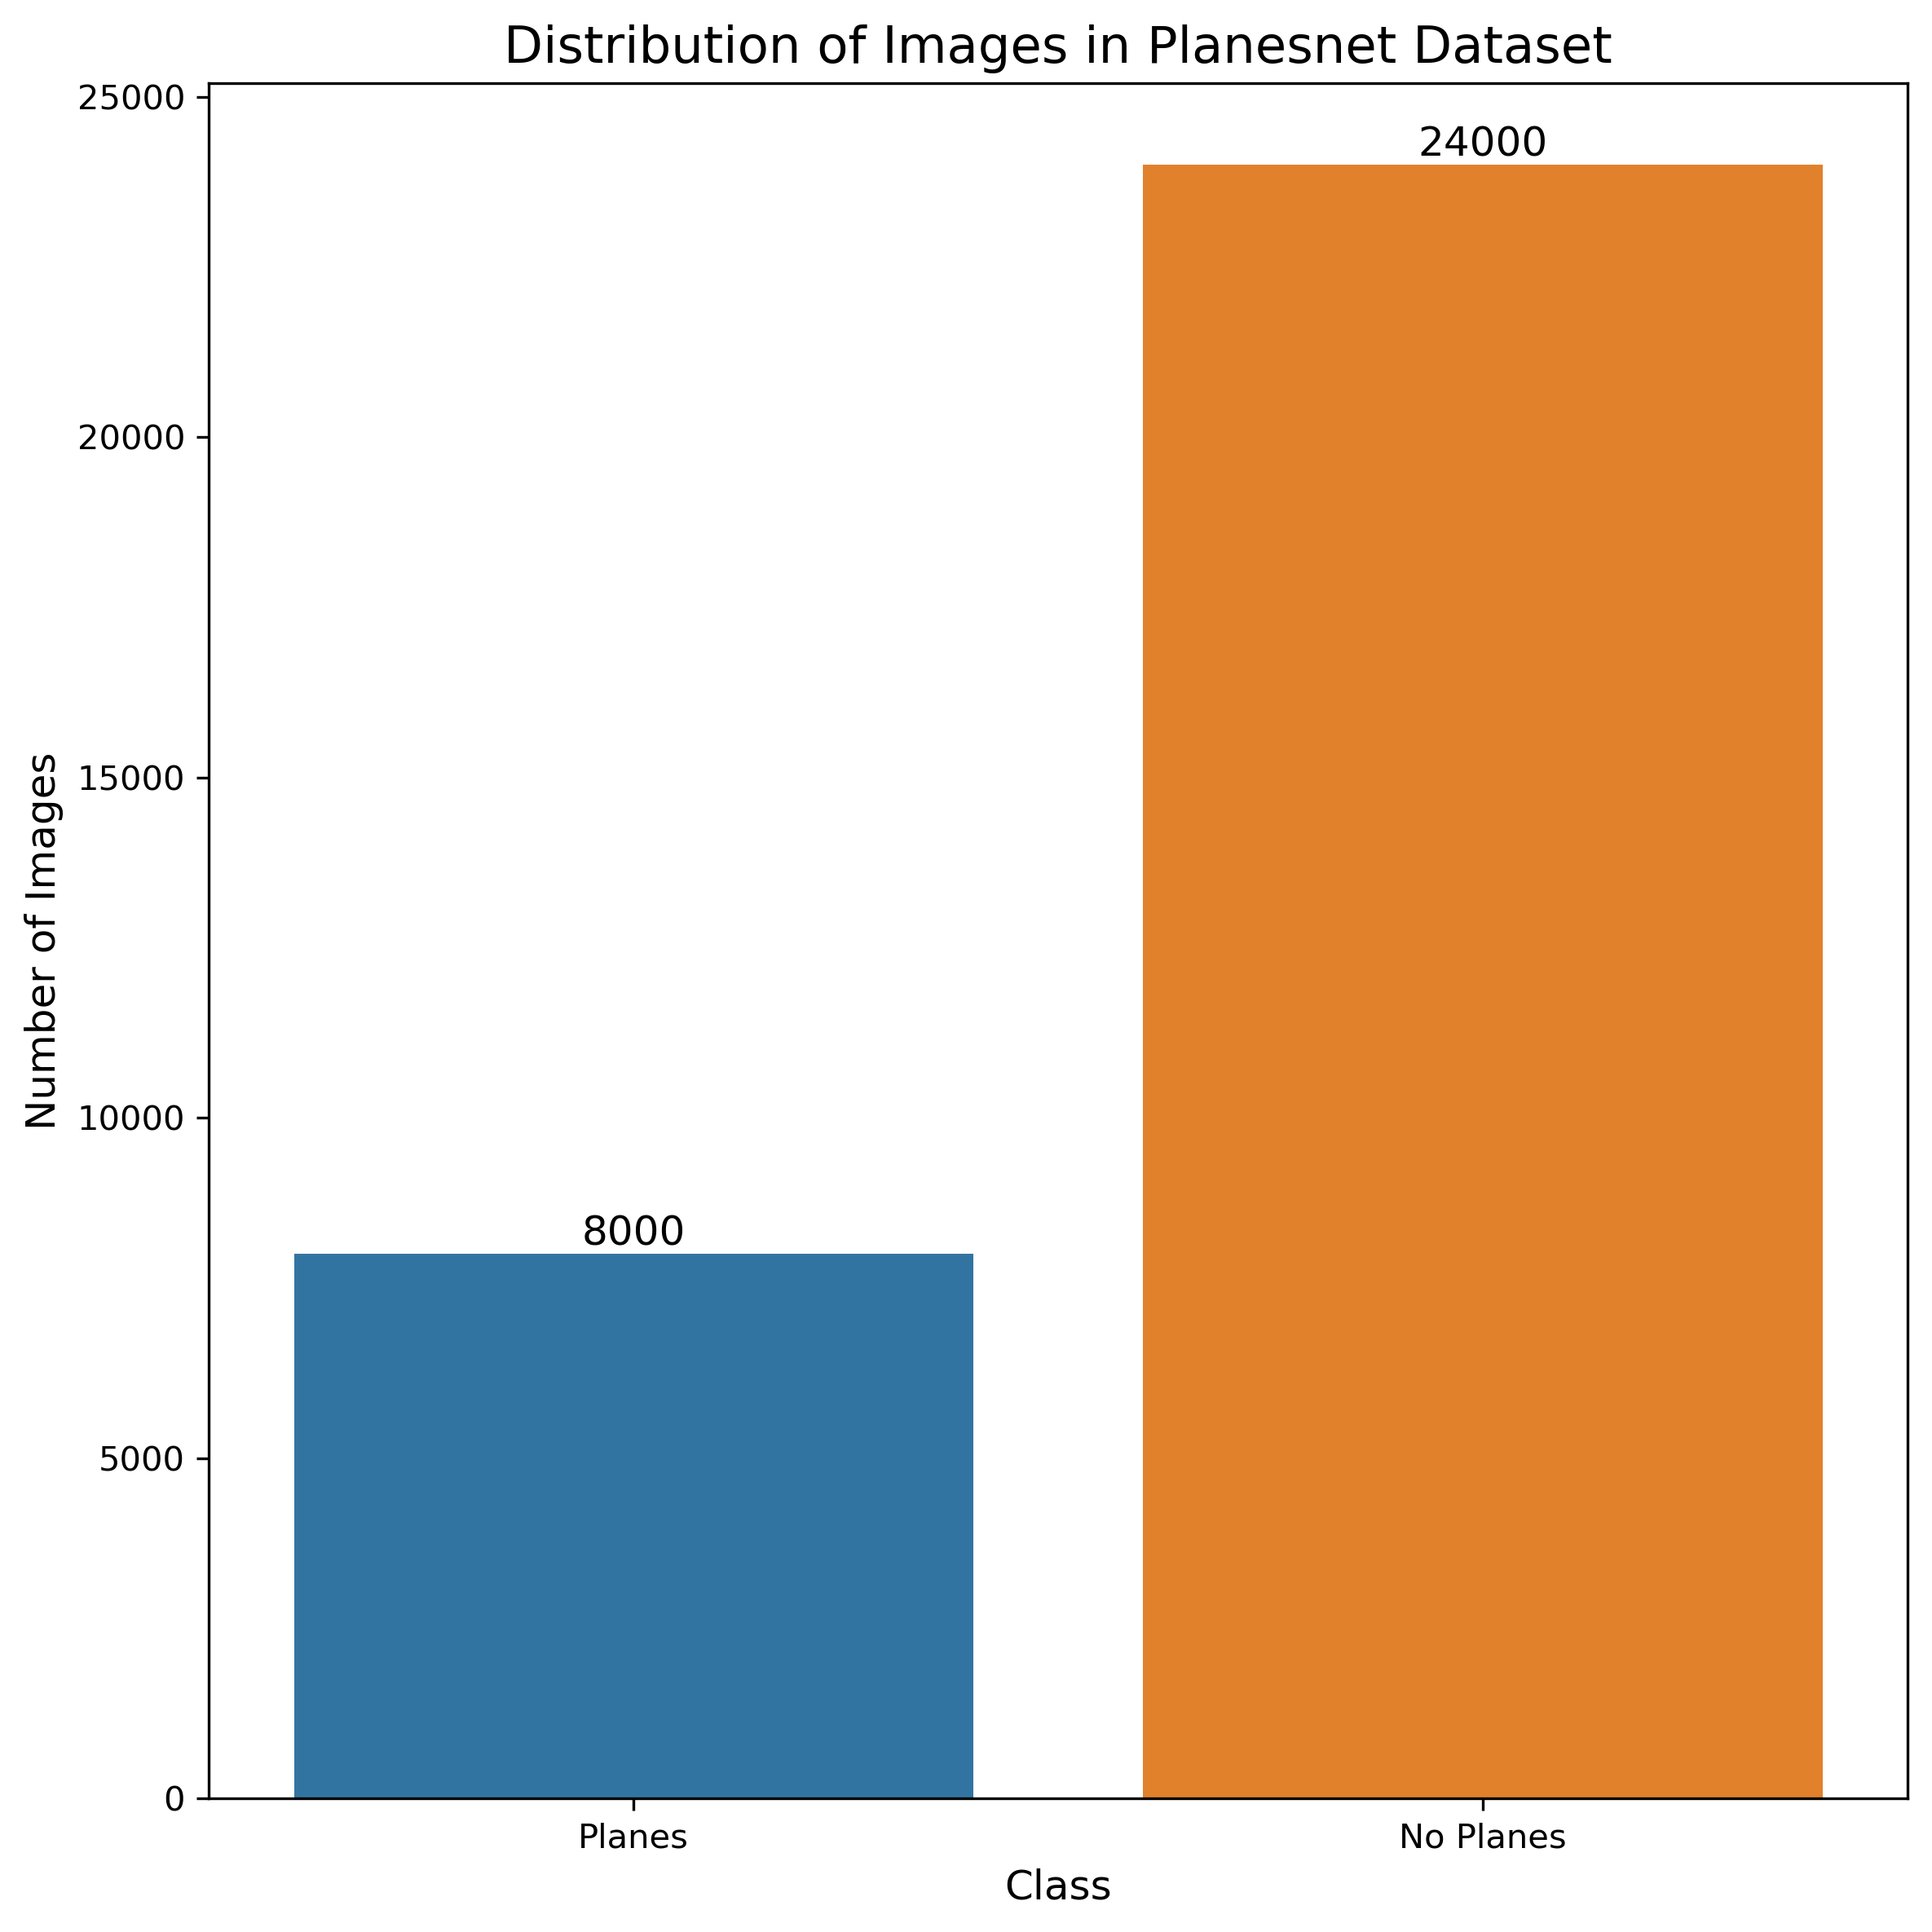

In [26]:
plot_and_save_data_distr_bar_char(class_planes, class_no_planes)

## pie chart


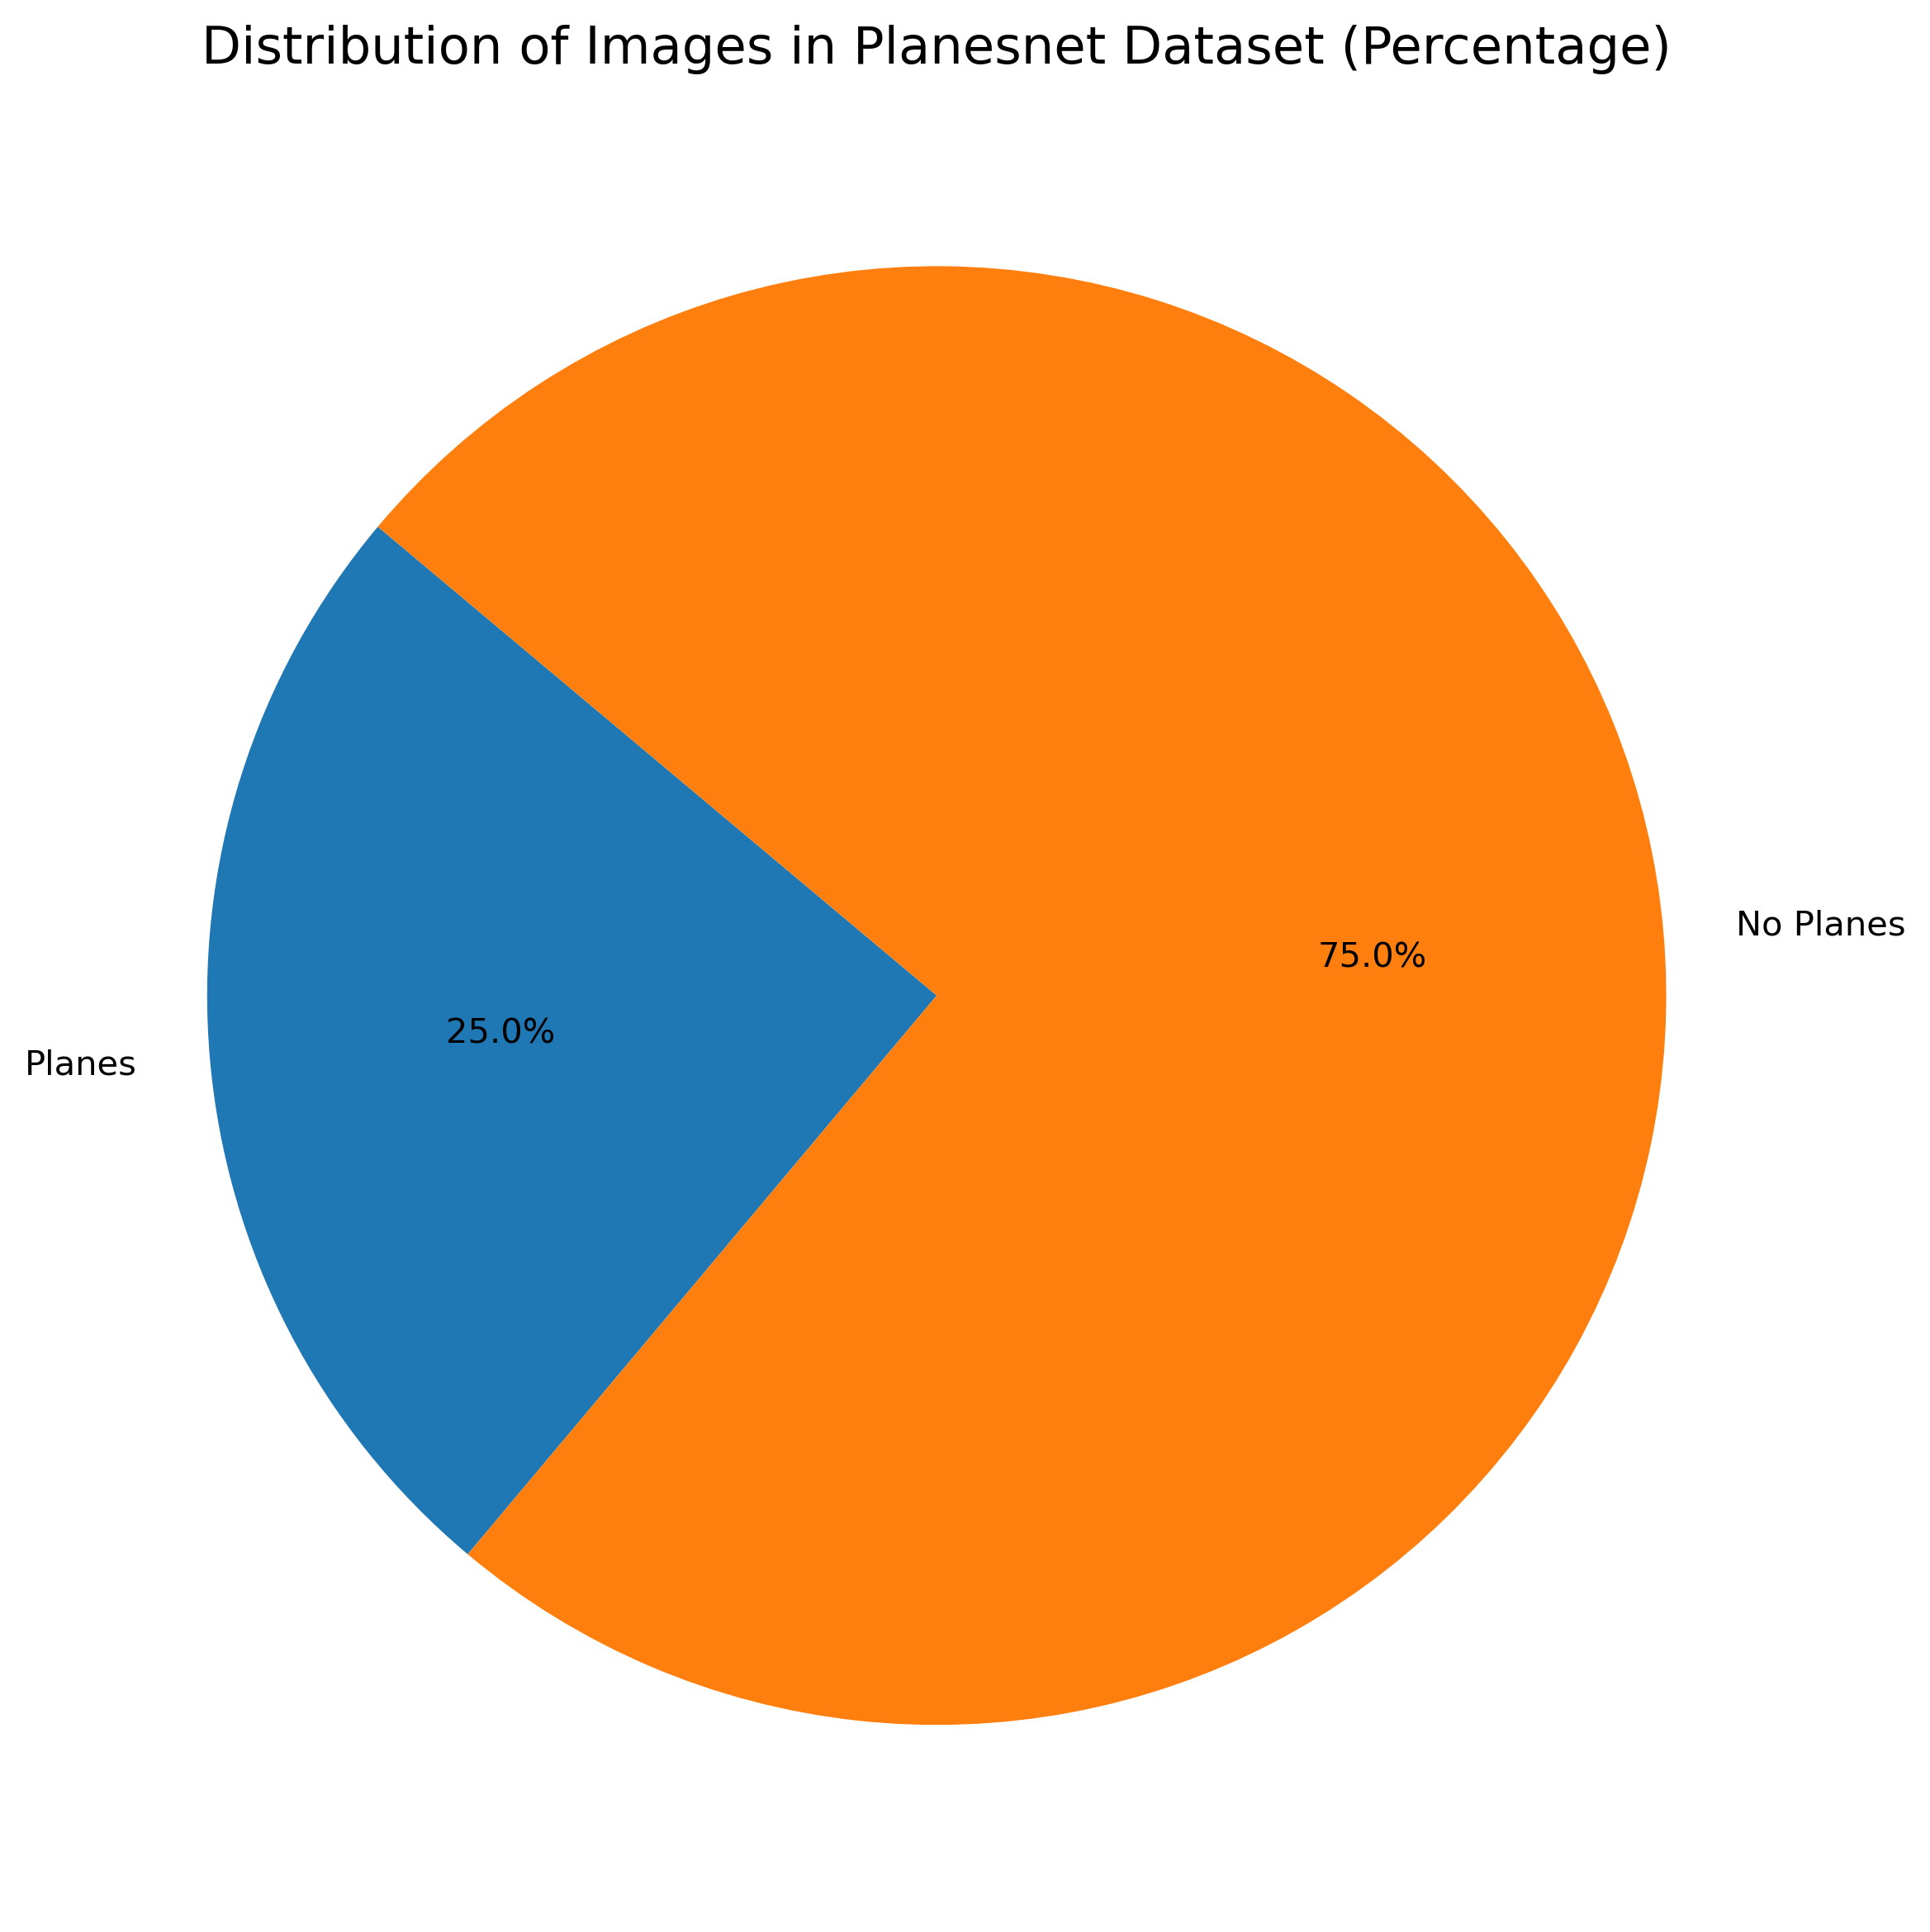

In [27]:
data = [len(class_planes), len(class_no_planes)]
class_labels = ["Planes", "No Planes"]  # Class labels

plot_and_save_pie_chart(data, class_labels)

# Using json


In [28]:
# helper_data


def get_correct_df(json_path: str):
    df = pd.read_json(json_path)
    df.drop(columns=["scene_ids", "locations"], inplace=True)

    pixel_columns_name = np.empty(1200, dtype=object)
    channels = ["r", "g", "b"]
    for c in channels:
        for p in range(400):
            pixel_columns_name[400 * channels.index(c) + p] = c + "_" + str(p)

    image_data = pd.DataFrame(df["data"].values.tolist(), columns=pixel_columns_name)
    labels = df.labels

    image_data = pd.concat([image_data, labels], axis=1)

    return image_data


class PlanesDatasetJson(torch.utils.data.Dataset):
    def __init__(
        self,
        dataframe: pd.DataFrame,
        is_Train: bool,
        normalized: bool,
        apply_aug: bool,
        data_transforms=None,
    ):
        super().__init__()

        self.df = dataframe.copy()
        self.is_Train = is_Train
        self.normalized = normalized
        self.apply_aug = apply_aug
        self.data_transforms = data_transforms

        self.y = self.df["labels"]
        self.X = self.df.drop("labels", inplace=False, axis=1)

        self.images = torch.from_numpy(self.X.to_numpy().reshape(-1, 3, 20, 20)).type(
            torch.float32
        )
        self.labels = torch.from_numpy(self.y.to_numpy()).type(torch.float32)

        self.augmentation = torchvision.transforms.Compose(
            [
                transforms.Resize(size=(20, 20)),
                # transforms.ToTensor(),  # already in tensor
                # transforms.TrivialAugmentWide(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(60),
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        images = self.images[idx]

        if self.data_transforms is not None:
            images = self.data_transforms(images)

        if self.normalized:  # default: False
            images = images / 255.0

        if self.is_Train and self.apply_aug:
            images = self.augmentation(images)

        return images, self.labels[idx]


def split_dataframe(dataframe: pd.DataFrame, test_size: float = 0.1):
    """Splits dataframe to df_train, df_val, df_test with specified split ratios"""

    # Avoid modifying original dataframe
    dataframe = dataframe.copy()
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)

    df_train_val, df_test = train_test_split(dataframe, test_size=test_size)
    df_train, df_val = train_test_split(df_train_val, test_size=test_size)

    return df_train, df_val, df_test


def get_dataloaders(
    apply_aug: bool,
    normalized: bool,
    batch_size: int,
    df: pd.DataFrame,
    test_size: float = 0.1,
    show_info: bool = True,
    data_transforms=None,
):
    """
    Splits dataframe into train, validation, and test dataframes,
    Creates train, val, test datasets,
    Then creates DataLoaders for each dataset.

    Args:
        df (pd.DataFrame): Dataframe to split.
        test_size (float, optional): Proportion of data for the test set. Defaults to 0.1.
        batch_size (int, optional): Batch size for DataLoaders. Defaults to BATCH_SIZE.

    Returns:
        tuple: Train, validation, and test data loaders.
    """

    ### Splits dataset
    df_train, df_val, df_test = split_dataframe(
        dataframe=df.copy(), test_size=test_size
    )

    if show_info:
        print(f"split ratio: {test_size}\n")
        print(
            f"Len of df:\n"
            f"df_train: ({len(df_train)}) | "
            f"df_train: ({len(df_val)}) | "
            f"df_train: ({len(df_test)})"
        )
        print(f"total length: {len(df_train) + len(df_val) + len(df_test)}")
        print(
            f"Train_Val : Test = {1 - test_size} : {test_size}"
            f"\nTrain : Val = {1 - test_size} : {test_size}"
        )

    ### Creates datasets
    if normalized:
        if apply_aug:
            train_dataset = PlanesDatasetJson(
                dataframe=df_train,
                is_Train=True,
                normalized=True,
                apply_aug=True,
                data_transforms=data_transforms,
            )
        else:  # train with no augmentation
            train_dataset = PlanesDatasetJson(
                dataframe=df_train,
                is_Train=True,
                normalized=True,
                apply_aug=False,
                data_transforms=data_transforms,
            )
        val_dataset = PlanesDatasetJson(
            dataframe=df_val,
            is_Train=False,
            normalized=True,
            apply_aug=False,
            data_transforms=data_transforms,
        )
        test_dataset = PlanesDatasetJson(
            dataframe=df_test,
            is_Train=False,
            normalized=True,
            apply_aug=False,
            data_transforms=data_transforms,
        )
    else:  # normalized = False
        if apply_aug:
            train_dataset = PlanesDatasetJson(
                dataframe=df_train,
                is_Train=True,
                normalized=False,
                apply_aug=True,
                data_transforms=data_transforms,
            )
        else:  # train with no augmentation
            train_dataset = PlanesDatasetJson(
                dataframe=df_train,
                is_Train=True,
                normalized=False,
                apply_aug=False,
                data_transforms=data_transforms,
            )

        val_dataset = PlanesDatasetJson(
            dataframe=df_val,
            is_Train=False,
            normalized=False,
            apply_aug=False,
            data_transforms=data_transforms,
        )
        test_dataset = PlanesDatasetJson(
            dataframe=df_test,
            is_Train=False,
            normalized=False,
            apply_aug=False,
            data_transforms=data_transforms,
        )

    if show_info:
        print(
            f"train_dataset: is_Train: ({train_dataset.is_Train}) | normalized: ({train_dataset.normalized}) | apply_aug: ({train_dataset.apply_aug})"
            f"\nval_dataset:   is_Train: ({val_dataset.is_Train}) | normalized: ({val_dataset.normalized}) | apply_aug: ({val_dataset.apply_aug})"
            f"\ntest_dataset:  is_Train: ({test_dataset.is_Train}) | normalized: ({test_dataset.normalized}) | apply_aug: ({test_dataset.apply_aug})"
        )

    ### Dataloaders
    train_dataloader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )
    val_dataloader = DataLoader(
        dataset=val_dataset, batch_size=batch_size, shuffle=False
    )
    test_dataloader = DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False
    )

    if show_info:
        print(
            f"Len of dataloaders:\n"
            f"train_dataloader: ({len(train_dataloader)}) | "
            f"val_dataloader: ({len(val_dataloader)}) | "
            f"test_dataloader: ({len(test_dataloader)})"
        )

    return train_dataloader, val_dataloader, test_dataloader


### LightningDataModule


class PlanesLightningDataModule(L.LightningDataModule):

    def __init__(
        self,
        dataframe: pd.DataFrame,
        normalized: bool,
        apply_aug: bool,
        batch_size: int,
        data_transforms=None,
        test_size=0.1,
    ):
        super().__init__()

        self.df = dataframe.copy()
        self.normalized = normalized
        self.apply_aug = apply_aug
        self.batch_size = batch_size
        self.data_transforms = data_transforms
        self.test_size = test_size

        self.augmentation = torchvision.transforms.Compose(
            [
                transforms.Resize(size=(20, 20)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(60),
            ]
        )

    def prepare_data(self) -> None:

        self.shuffled_dataframe = self.df.sample(frac=1).reset_index(drop=True)
        df_train_val, self.df_test = train_test_split(
            self.shuffled_dataframe, test_size=self.test_size
        )
        self.df_train, self.df_val = train_test_split(
            df_train_val, test_size=self.test_size
        )

        # calculate sample weights:
        train_class_counts = self.df_train["labels"].value_counts()
        train_sampling_weights = [
            1 / train_class_counts[i] for i in self.df_train.labels.values
        ]
        self.train_sampler = WeightedRandomSampler(
            weights=train_sampling_weights,
            num_samples=len(self.df_train),
            replacement=True,
        )

        val_class_counts = self.df_val["labels"].value_counts()
        val_sampling_weights = [
            1 / val_class_counts[i] for i in self.df_val.labels.values
        ]
        self.val_sampler = WeightedRandomSampler(
            weights=val_sampling_weights, num_samples=len(self.df_val), replacement=True
        )

        test_class_counts = self.df_test["labels"].value_counts()
        test_sampling_weights = [
            1 / test_class_counts[i] for i in self.df_test.labels.values
        ]
        self.test_sampler = WeightedRandomSampler(
            weights=test_sampling_weights,
            num_samples=len(self.df_test),
            replacement=True,
        )

        print(
            f"length of dataloaders:\n"
            f"train_dataloader: ({int(len(self.df_train)/self.batch_size)}) | "
            f"val_dataloader: ({int(len(self.df_val)/self.batch_size)}) | "
            f"test_dataloader: ({int(len(self.df_test)/self.batch_size)})"
        )

    def setup(self, stage: str = None):
        self.train_dataset = PlanesDatasetJson(
            dataframe=self.df_train,
            is_Train=True,
            normalized=self.normalized,
            apply_aug=self.apply_aug,
            data_transforms=self.data_transforms,
        )

        self.val_dataset = PlanesDatasetJson(
            dataframe=self.df_val,
            is_Train=False,
            normalized=self.normalized,
            apply_aug=False,
            data_transforms=self.data_transforms,
        )
        self.test_dataset = PlanesDatasetJson(
            dataframe=self.df_test,
            is_Train=False,
            normalized=self.normalized,
            apply_aug=False,
            data_transforms=self.data_transforms,
        )

    def train_dataloader(self):
        self.train_dl = DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            drop_last=True,
            sampler=self.train_sampler,
        )
        return self.train_dl

    def val_dataloader(self):
        self.val_dl = DataLoader(
            dataset=self.val_dataset,
            batch_size=self.batch_size,
            drop_last=False,
            sampler=self.val_sampler,
        )
        return self.val_dl

    def test_dataloader(self):
        self.test_dl = DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            drop_last=False,
            sampler=self.test_sampler,
        )
        return self.test_dl

    def predict_dataloader(self):
        self.predict_dl = DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            drop_last=False,
            sampler=self.test_sampler,
        )
        return self.predict_dl

In [29]:
image_data = get_correct_df("planesnet.json")
image_data.head()

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,...,b_391,b_392,b_393,b_394,b_395,b_396,b_397,b_398,b_399,labels
0,206,195,187,183,177,175,174,193,198,197,...,191,193,197,196,198,231,224,194,164,1
1,215,209,200,196,192,197,205,168,155,160,...,190,185,182,192,201,204,205,207,210,1
2,204,214,220,219,213,205,198,193,199,186,...,171,174,173,174,176,171,167,163,157,1
3,179,174,179,178,173,170,168,168,168,170,...,150,152,164,171,171,171,170,169,163,1
4,222,222,218,214,208,205,207,206,206,207,...,164,164,161,156,163,164,166,158,147,1


# Custom dataset: PlanesDatasetJson


# Pytorch Model


In [30]:
class SimpleCNN_V1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.layers = torch.nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                stride=(2, 2),
                kernel_size=(3, 3),
                padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                stride=(2, 2),
                kernel_size=(3, 3),
                padding=1,
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Conv2d(
                in_channels=64,
                out_channels=16,
                stride=(2, 2),
                kernel_size=(3, 3),
                padding=1,
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=0.02),
            nn.Flatten(),
            nn.Linear(in_features=16 * 3 * 3, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=num_classes),
            # nn.Sigmoid(), ## If not using nn.Sigmoid(), then loss=torch.nn.BCEWithLogitsLoss()
            ## If using nn.Sigmoid(), then loss = nn.BCELoss(), this loss needs pred be between [0, 1]
        )

    def forward(self, x):
        x = self.layers(x)
        return x

# LightningDataModule


In [31]:
### LightningDataModule


class PlanesLightningDataModule(L.LightningDataModule):

    def __init__(
        self,
        dataframe: pd.DataFrame,
        normalized: bool,
        apply_aug: bool,
        batch_size: int,
        data_transforms=None,
        test_size=0.1,
    ):
        super().__init__()

        self.df = dataframe.copy()
        self.normalized = normalized
        self.apply_aug = apply_aug
        self.batch_size = batch_size
        self.data_transforms = data_transforms
        self.test_size = test_size

        self.augmentation = torchvision.transforms.Compose(
            [
                transforms.Resize(size=(20, 20)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(60),
            ]
        )

    def prepare_data(self) -> None:

        self.shuffled_dataframe = self.df.sample(frac=1).reset_index(drop=True)
        df_train_val, self.df_test = train_test_split(
            self.shuffled_dataframe, test_size=self.test_size
        )
        self.df_train, self.df_val = train_test_split(
            df_train_val, test_size=self.test_size
        )

        # calculate sample weights:
        train_class_counts = self.df_train["labels"].value_counts()
        train_sampling_weights = [
            1 / train_class_counts[i] for i in self.df_train.labels.values
        ]
        self.train_sampler = WeightedRandomSampler(
            weights=train_sampling_weights,
            num_samples=len(self.df_train),
            replacement=True,
        )

        val_class_counts = self.df_val["labels"].value_counts()
        val_sampling_weights = [
            1 / val_class_counts[i] for i in self.df_val.labels.values
        ]
        self.val_sampler = WeightedRandomSampler(
            weights=val_sampling_weights, num_samples=len(self.df_val), replacement=True
        )

        test_class_counts = self.df_test["labels"].value_counts()
        test_sampling_weights = [
            1 / test_class_counts[i] for i in self.df_test.labels.values
        ]
        self.test_sampler = WeightedRandomSampler(
            weights=test_sampling_weights,
            num_samples=len(self.df_test),
            replacement=True,
        )

        print(
            f"length of dataloaders:\n"
            f"train_dataloader: ({int(len(self.df_train)/self.batch_size)}) | "
            f"val_dataloader: ({int(len(self.df_val)/self.batch_size)}) | "
            f"test_dataloader: ({int(len(self.df_test)/self.batch_size)})"
        )

    def setup(self, stage: str = None):
        self.train_dataset = PlanesDatasetJson(
            dataframe=self.df_train,
            is_Train=True,
            normalized=self.normalized,
            apply_aug=self.apply_aug,
            data_transforms=self.data_transforms,
        )

        self.val_dataset = PlanesDatasetJson(
            dataframe=self.df_val,
            is_Train=False,
            normalized=self.normalized,
            apply_aug=False,
            data_transforms=self.data_transforms,
        )
        self.test_dataset = PlanesDatasetJson(
            dataframe=self.df_test,
            is_Train=False,
            normalized=self.normalized,
            apply_aug=False,
            data_transforms=self.data_transforms,
        )

    def train_dataloader(self):
        self.train_dl = DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            drop_last=True,
            sampler=self.train_sampler,
        )
        return self.train_dl

    def val_dataloader(self):
        self.val_dl = DataLoader(
            dataset=self.val_dataset,
            batch_size=self.batch_size,
            drop_last=False,
            sampler=self.val_sampler,
        )
        return self.val_dl

    def test_dataloader(self):
        self.test_dl = DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            drop_last=False,
            sampler=self.test_sampler,
        )
        return self.test_dl

    def predict_dataloader(self):
        self.predict_dl = DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            drop_last=False,
            sampler=self.test_sampler,
        )
        return self.predict_dl

# Experiement 1: WeightedRandomSampler


In [32]:
### for powerpoint slides

dm = PlanesLightningDataModule(
    dataframe=image_data,
    normalized=True,  # [0, 1]
    apply_aug=True,
    batch_size=64,
    data_transforms=None,
    test_size=0.2,
)

dm.prepare_data()
dm.setup()


full_dataset = PlanesDatasetJson(
    dataframe=dm.shuffled_dataframe,
    is_Train=True,
    normalized=True,
    apply_aug=False,
    data_transforms=None,
)

dm_shuffled_df = dm.shuffled_dataframe

length of dataloaders:
train_dataloader: (320) | val_dataloader: (80) | test_dataloader: (100)


length of dataloaders:
train_dataloader: (320) | val_dataloader: (80) | test_dataloader: (100)

len of dataset: 32000 | batch_size: 32
len of dataloader: 1000


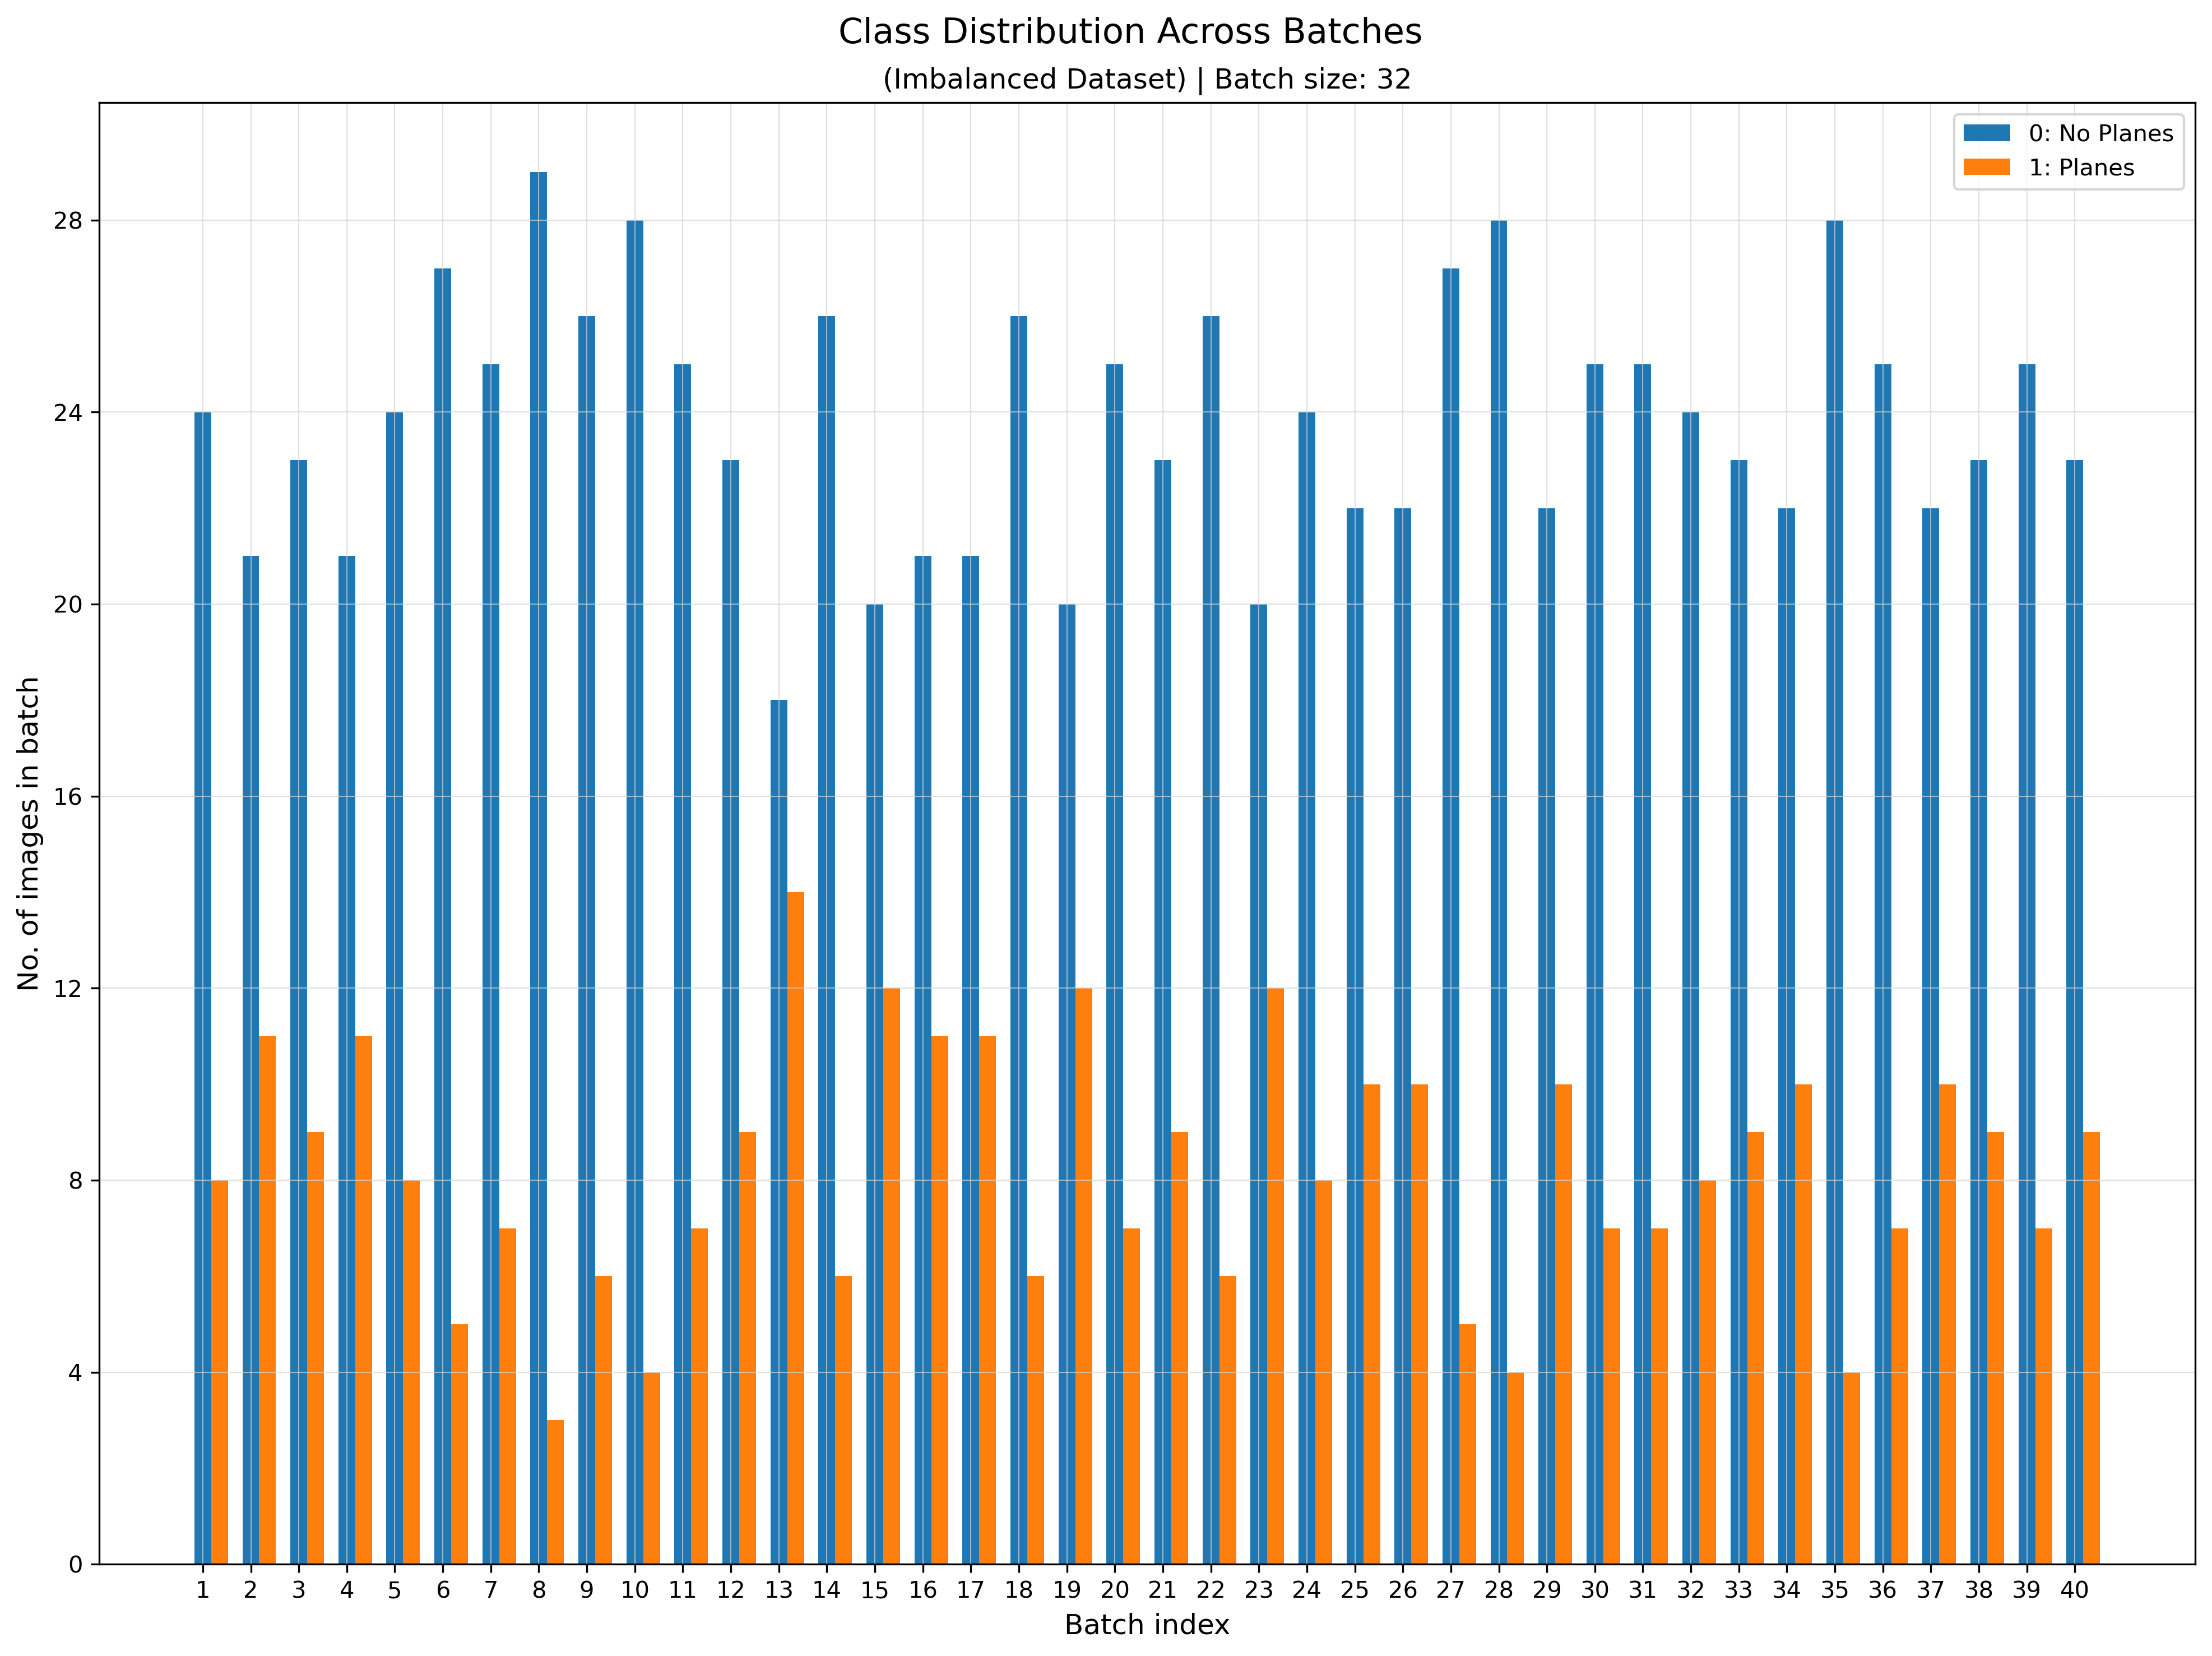

In [33]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import seaborn as sns
import matplotlib.pyplot as plt


dm = PlanesLightningDataModule(
    dataframe=image_data,
    normalized=True,  # [0, 1]
    apply_aug=True,
    batch_size=64,
    data_transforms=None,
    test_size=0.2,
)

dm.prepare_data()
dm.setup()


full_dataset = PlanesDatasetJson(
    dataframe=dm.shuffled_dataframe,
    is_Train=True,
    normalized=True,
    apply_aug=False,
    data_transforms=None,
)


dm_shuffled_df = dm.shuffled_dataframe
class_counts = dm_shuffled_df["labels"].value_counts()
sample_weights = [1 / class_counts[i] for i in dm_shuffled_df.labels.values]


batch_size = 32

### Create dataloader without WeightedRandomSampler ###
dataloader_no_sampler = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

### Create dataloader with WeightedRandomSampler ###
sampler = WeightedRandomSampler(
    weights=sample_weights, num_samples=len(full_dataset), replacement=True
)
dataloader_with_sampler = DataLoader(
    full_dataset, batch_size=batch_size, sampler=sampler
)

print()
print(f"len of dataset: {len(full_dataset)} | batch_size: {batch_size}")
print(f"len of dataloader: {len(dataloader_with_sampler)}")


visualize_dataloader(
    dataloader_no_sampler, balanced=False, collect_n_batches=40, batch_size=batch_size
)

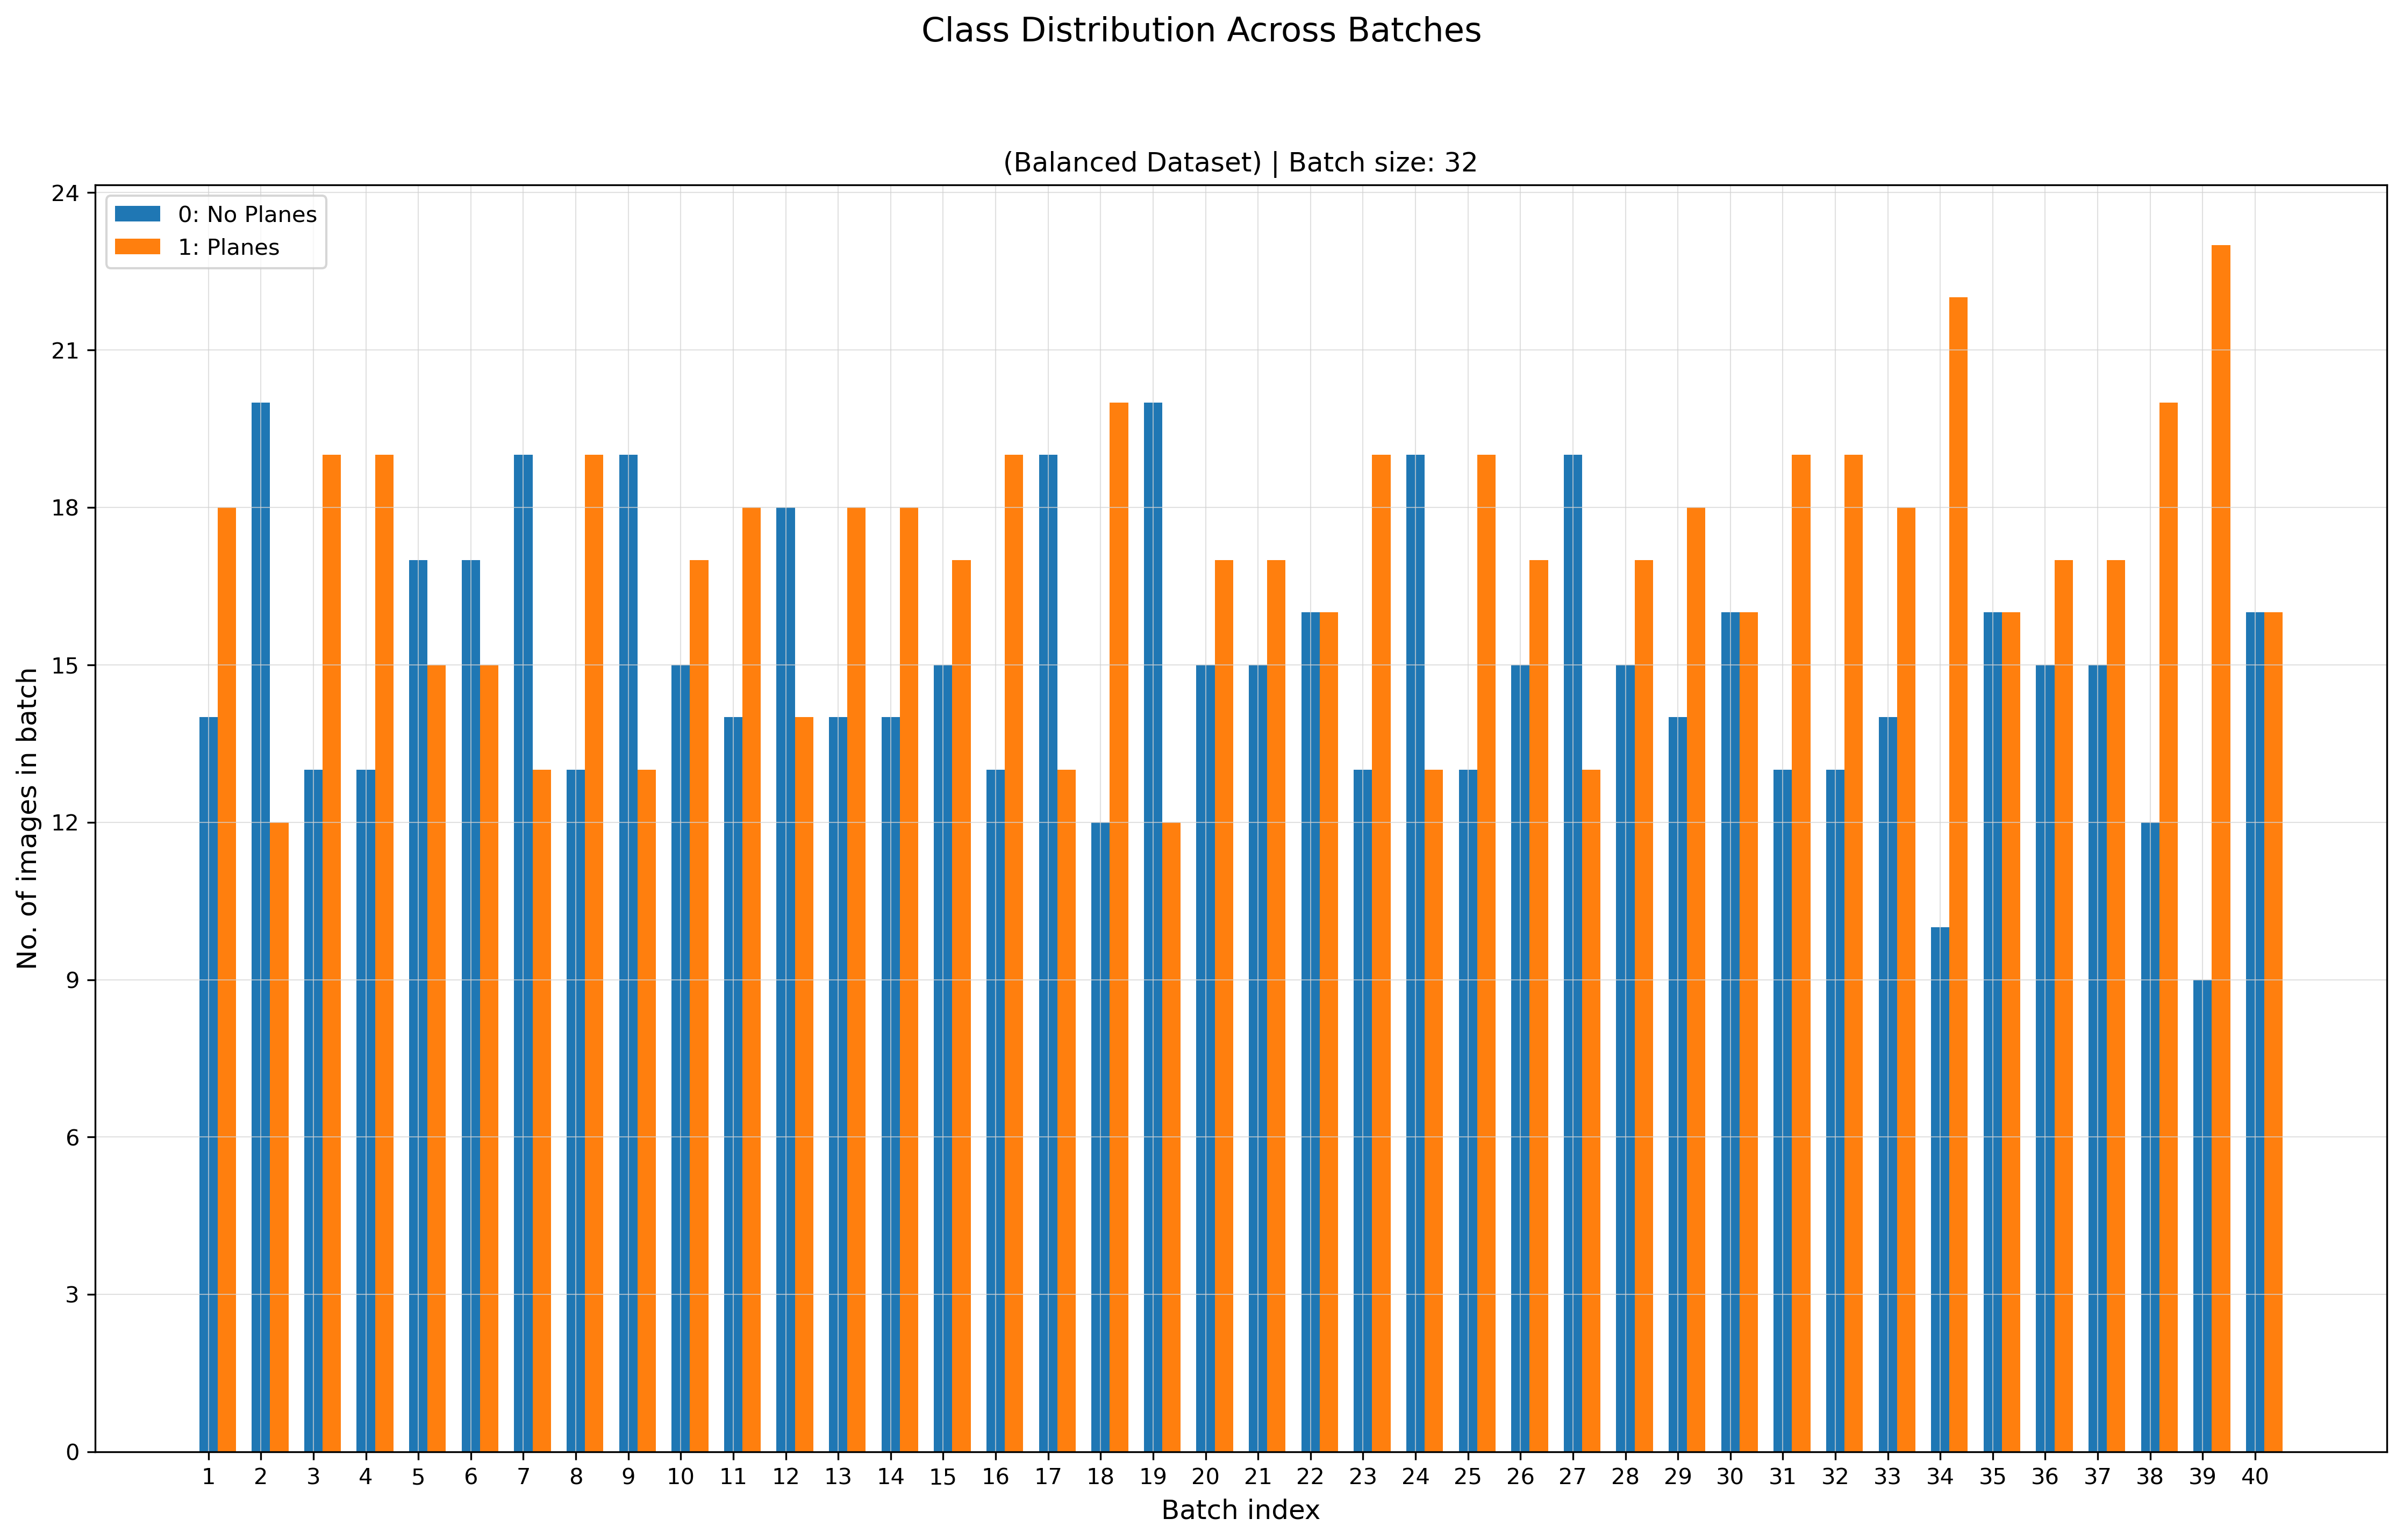

In [34]:
visualize_dataloader(
    dataloader_with_sampler,
    balanced=True,
    collect_n_batches=40,
    batch_size=batch_size,
)

In [35]:
RANDOM_SEED = 123
L.seed_everything(RANDOM_SEED)

dm = PlanesLightningDataModule(
    dataframe=image_data,
    normalized=True,  # [0, 1]
    apply_aug=True,
    batch_size=64,
    data_transforms=None,
    test_size=0.2,
)

dm.prepare_data()
dm.setup()

Seed set to 123


length of dataloaders:
train_dataloader: (320) | val_dataloader: (80) | test_dataloader: (100)


max and min of images[0]: 1.0, 0.0
images shape: torch.Size([64, 3, 20, 20])


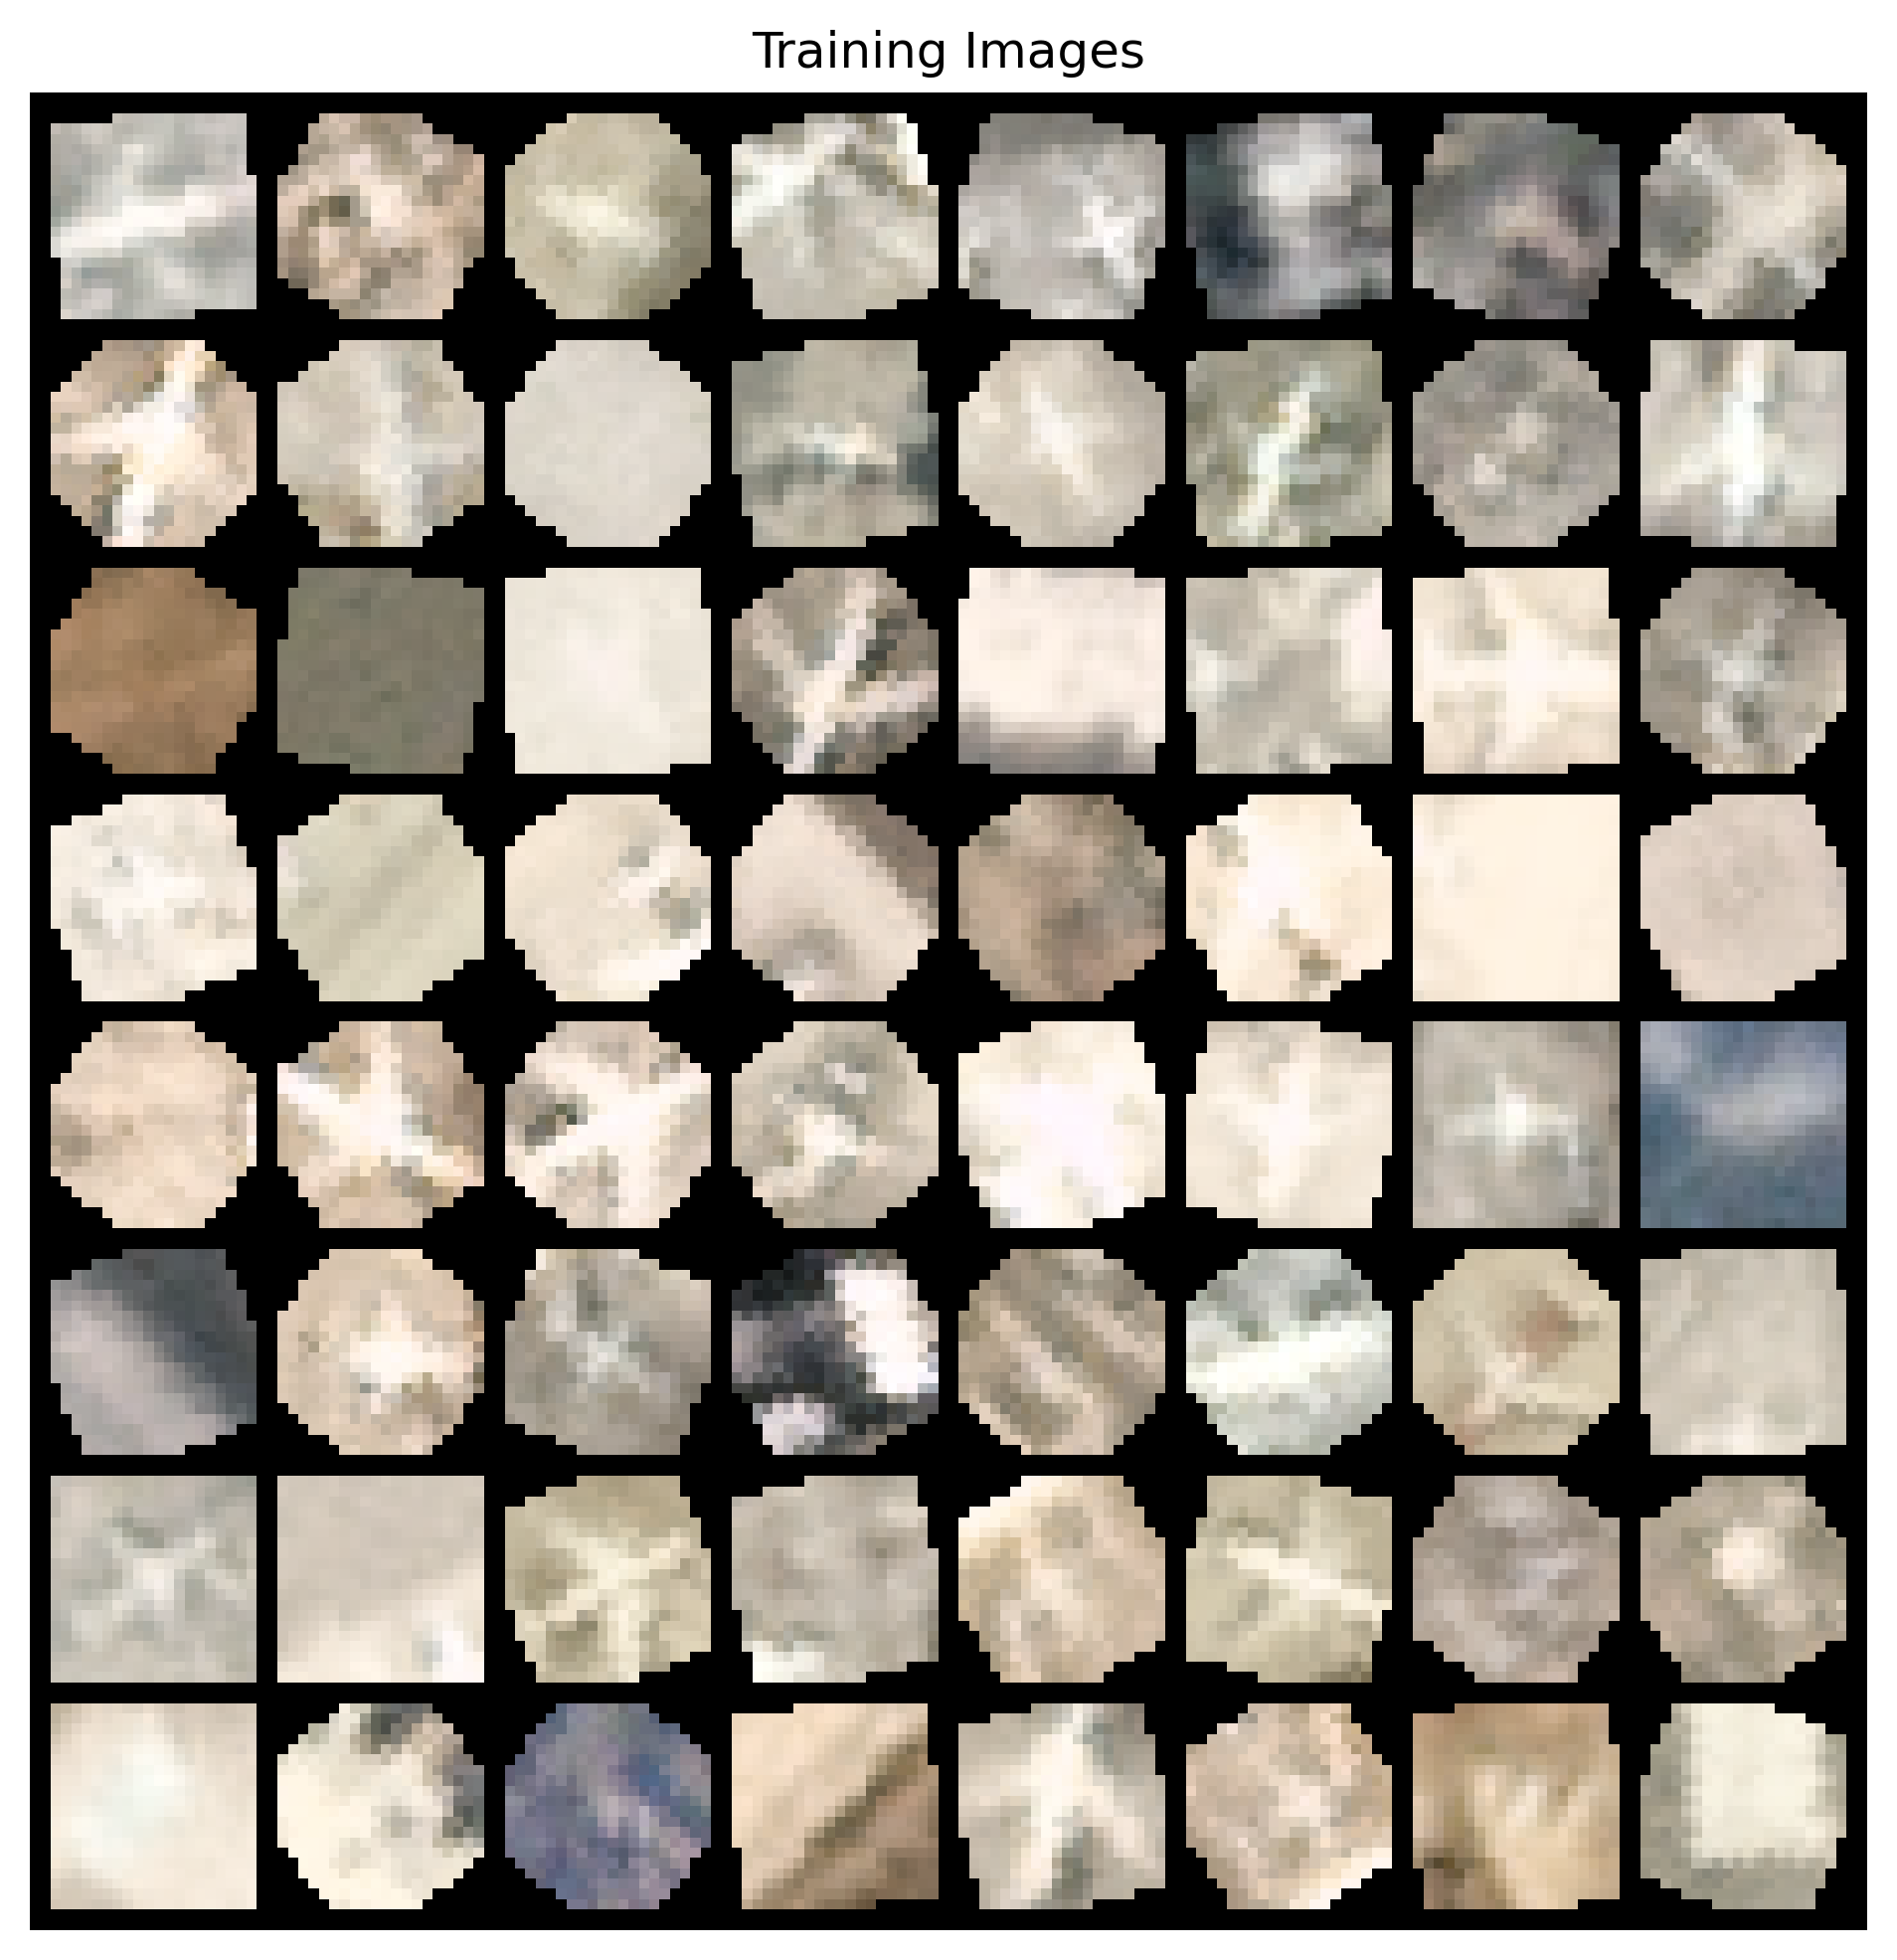

In [36]:
for images, labels in dm.train_dataloader():
    break

# print(f"images[0] values:\n{images[61]}")
print(f"max and min of images[0]: {images[61].max()}, {images[61].min()}")
print(f"images shape: {images.shape}")

plt.figure(figsize=(8, 8), dpi=300)
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    torchvision.utils.make_grid(images[:64], padding=2, normalize=True).permute(1, 2, 0)
)
plt.show()

images shape: torch.Size([64, 3, 20, 20])


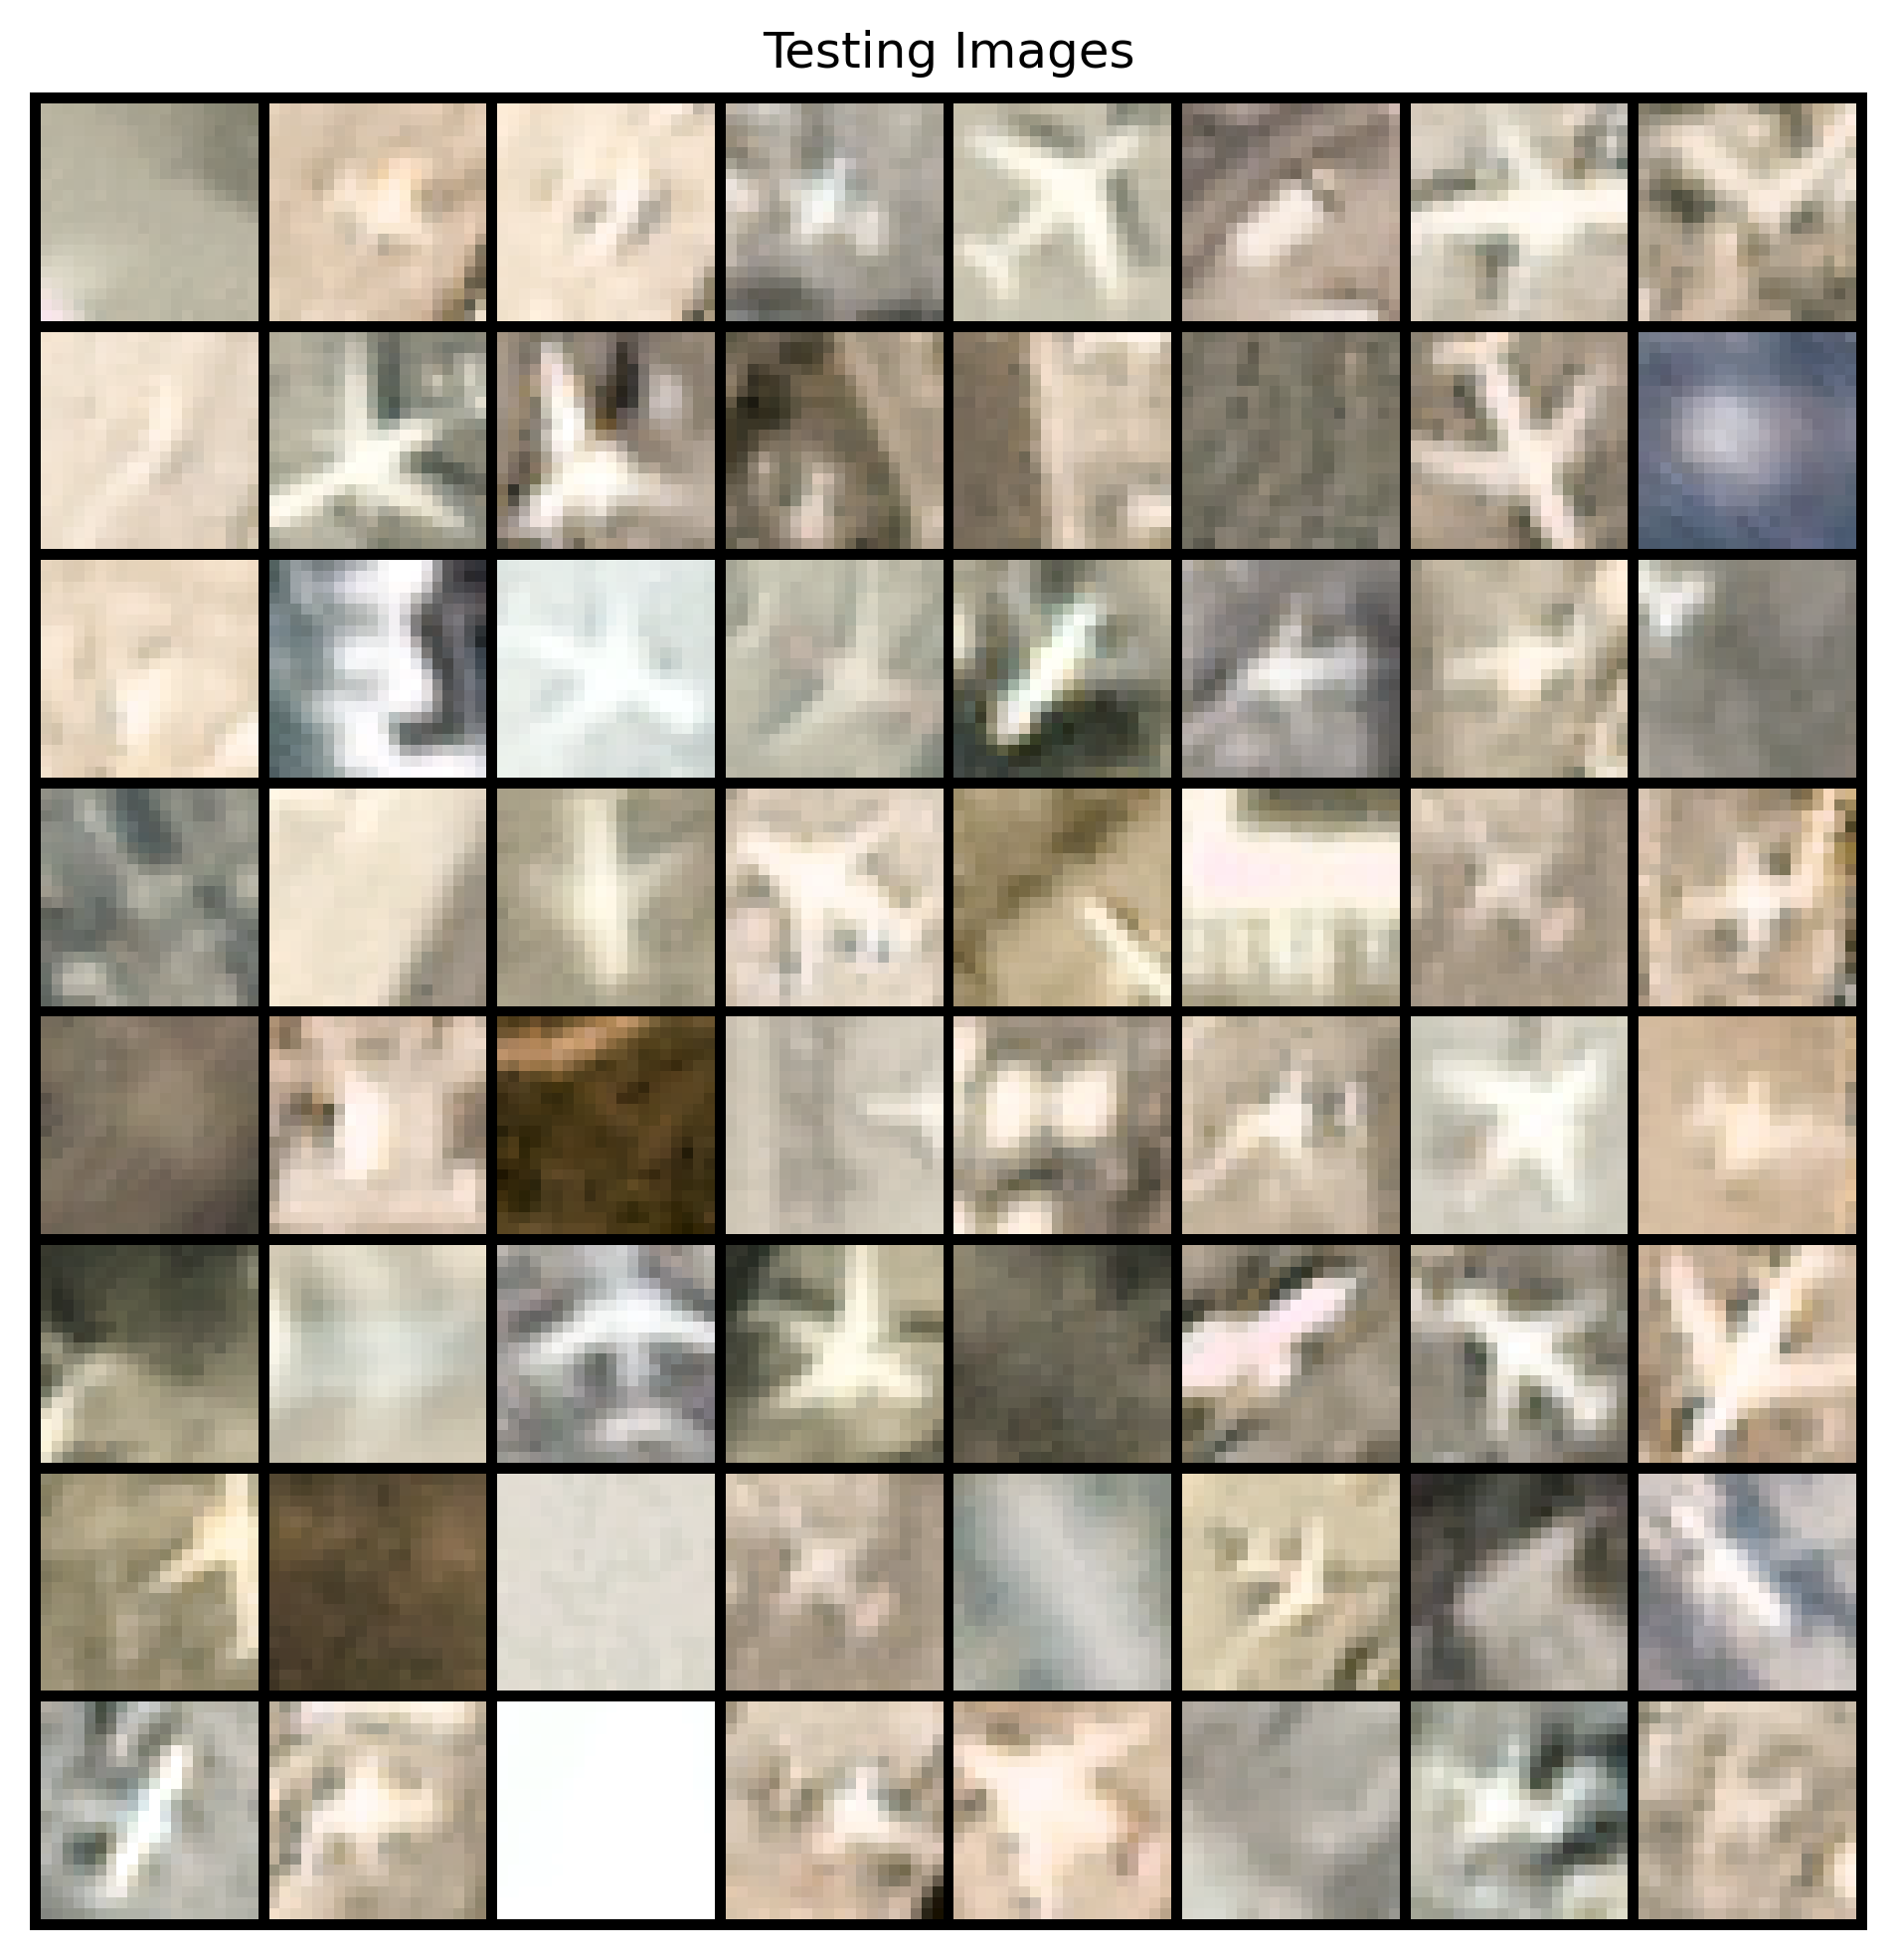

In [37]:
for images, labels in dm.test_dataloader():
    break

print(f"images shape: {images.shape}")

plt.figure(figsize=(8, 8), dpi=300)
plt.axis("off")
plt.title("Testing Images")
plt.imshow(
    torchvision.utils.make_grid(images[:64], padding=1, normalize=True).permute(1, 2, 0)
)
plt.show()

# LightningModule


In [38]:
### LightningModule
class PlanesLightningModule(L.LightningModule):
    def __init__(self, model: torch.nn.Module, learning_rate: float, input_size):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        self.input_size = input_size
        self.example_input_array = torch.rand((1, 3, self.input_size, self.input_size))
        self.save_hyperparameters(ignore=["model"])

        ### For plotting purposes
        self.train_loss_list = []
        self.val_loss_list = []
        self.test_loss_list = []

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        images, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.log(
            "train_loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=True
        )
        self.train_loss_list.append(loss.item())  # Append loss for plotting
        return loss

    def validation_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.log(
            "val_loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=True
        )
        self.val_loss_list.append(loss.item())
        return loss

    def test_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.log(
            "test_loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=True
        )
        self.test_loss_list.append(loss.item())
        return loss

    def predict_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        predictions = torch.argmax(logits, dim=1)
        return predictions

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]

    def plot_metrics(self):

        averaging_iterations = 100
        # Ensure data on CPU before plotting
        cpu_train_loss = self.train_loss_list
        cpu_val_loss = self.val_loss_list
        cpu_test_loss = self.test_loss_list
        # cpu_train_acc = [acc.cpu().item() for acc in self.train_acc_list]

        # Plot Loss
        model_details = (
            f"model: {self.model.__class__.__name__}, lr: {self.learning_rate}"
        )
        main_title = "Training vs Validation Loss per mini-batches"

        plt.figure(figsize=(15, 8))

        ### new
        ax1 = plt.subplot(1, 1, 1)
        ax1.plot(cpu_train_loss, label="Training Loss")
        ax1.plot(cpu_val_loss, label="Validation Loss", linestyle="--")
        plt.xlabel("Num of mini-batches", fontsize=12)
        plt.ylabel("Loss", fontsize=12)
        plt.suptitle(main_title, fontsize=15)
        plt.title(model_details, fontsize=12)

        # plot running avg
        kernel = np.ones(averaging_iterations) / averaging_iterations
        smoothed_train_loss = np.convolve(cpu_train_loss, kernel, mode="valid")
        smoothed_val_loss = np.convolve(cpu_val_loss, kernel, mode="valid")

        ax1.plot(smoothed_train_loss, label="Running Average Training loss")
        ax1.plot(smoothed_val_loss, label="Running Average Validation loss")

        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"plots/minibatch_train_val_loss_lightning", dpi=300)
        plt.show()

    def on_train_end(self):
        self.plot_metrics()

In [39]:
RANDOM_SEED = 123
INPUT_SIZE = 20

pytorch_model = SimpleCNN_V1(num_classes=2)
lightning_model = PlanesLightningModule(
    pytorch_model, learning_rate=0.05, input_size=INPUT_SIZE
)
summary = m_summary(lightning_model, max_depth=-1)
print(summary)

   | Name            | Type         | Params | In sizes        | Out sizes      
--------------------------------------------------------------------------------------
0  | model           | SimpleCNN_V1 | 33.6 K | [1, 3, 20, 20]  | [1, 2]         
1  | model.layers    | Sequential   | 33.6 K | [1, 3, 20, 20]  | [1, 2]         
2  | model.layers.0  | Conv2d       | 896    | [1, 3, 20, 20]  | [1, 32, 10, 10]
3  | model.layers.1  | BatchNorm2d  | 64     | [1, 32, 10, 10] | [1, 32, 10, 10]
4  | model.layers.2  | LeakyReLU    | 0      | [1, 32, 10, 10] | [1, 32, 10, 10]
5  | model.layers.3  | Conv2d       | 18.5 K | [1, 32, 10, 10] | [1, 64, 5, 5]  
6  | model.layers.4  | BatchNorm2d  | 128    | [1, 64, 5, 5]   | [1, 64, 5, 5]  
7  | model.layers.5  | LeakyReLU    | 0      | [1, 64, 5, 5]   | [1, 64, 5, 5]  
8  | model.layers.6  | Conv2d       | 9.2 K  | [1, 64, 5, 5]   | [1, 16, 3, 3]  
9  | model.layers.7  | BatchNorm2d  | 32     | [1, 16, 3, 3]   | [1, 16, 3, 3]  
10 | model.layers.8  |

# Training


Seed set to 123
Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/envs/torch/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

torch     : 2.2.2
 lightning: not installed

mps


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/torch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(

   | Name            | Type         | Params | In sizes        | Out sizes      
--------------------------------------------------------------------------------------
0  | model           | SimpleCNN_V1 | 33.6 K | [1, 3, 20, 20]  | [1, 2]         
1  | model.layers    | Sequential   | 33.6 K | [1, 3, 20, 20]  | [1, 2]         
2  | model.layers.0  | Conv2d       | 896    | [1, 3, 20, 20]  | [1, 32, 10, 10]
3  | model.layers.1  | BatchNorm2d  | 64     | [1, 32, 10, 10] | [1, 32, 10, 10]
4  | model.layers.2  | LeakyReLU    | 0      | [1, 32, 10, 10] | [1, 32, 10, 10]
5  | model.layers.3  | Conv2d       | 18.5 K | [1, 32, 10, 10] | [1, 64, 5, 5]  
6  | model.layers.4  | BatchNorm2d  | 128    | [1, 64, 5, 5]   | [1, 64, 5, 5]  


length of dataloaders:
train_dataloader: (320) | val_dataloader: (80) | test_dataloader: (100)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


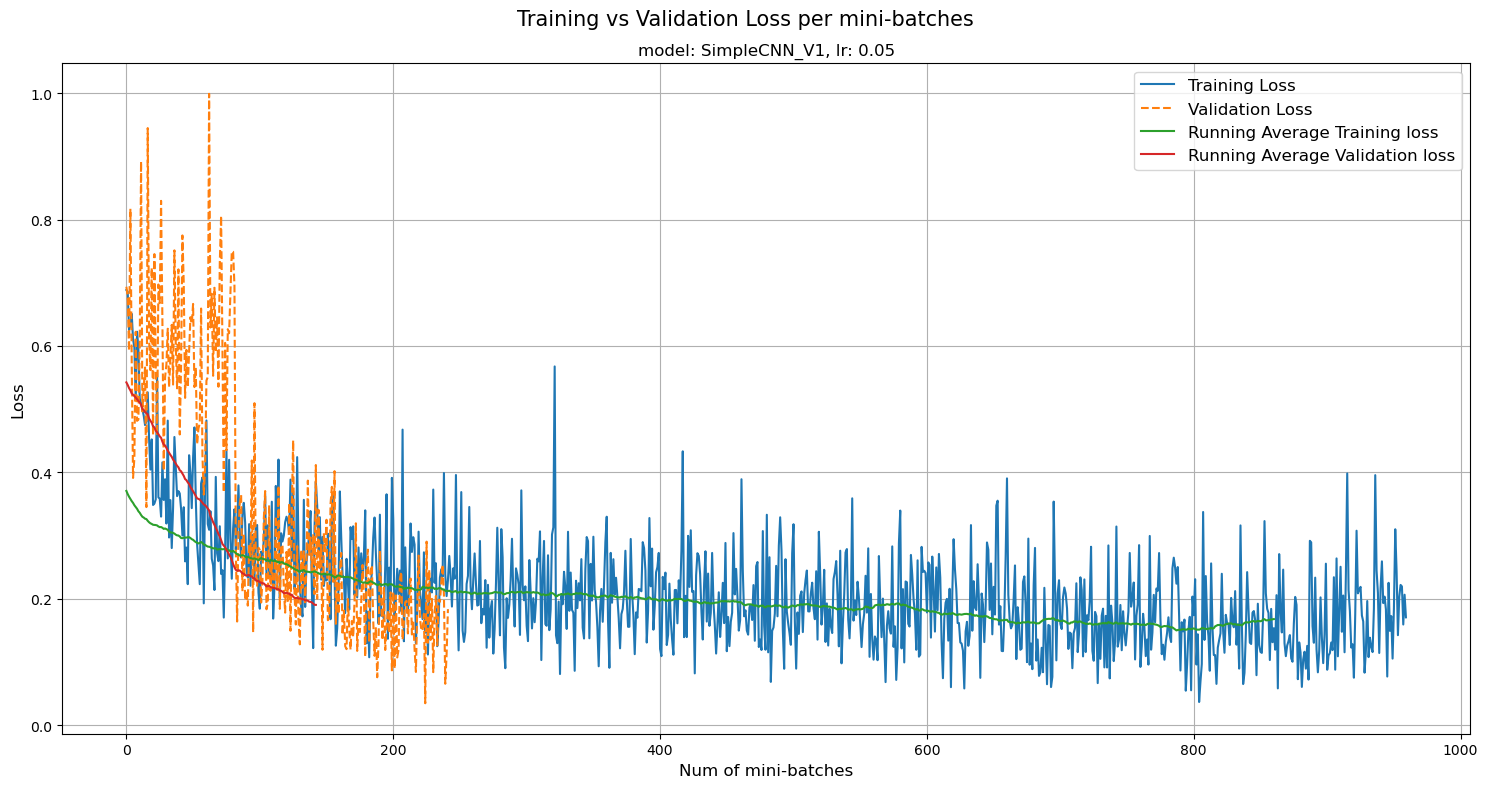

Training time on mps: 14.001 seconds


In [40]:
print(watermark(packages="torch, lightning", python=True))
print(device)

RANDOM_SEED = 123
IMG_SIZE = 20
BATCH_SIZE = 64
TEST_SIZE = 0.2

NUM_EPOCHS = 3
LEARNING_RATE = 0.05


L.seed_everything(RANDOM_SEED)

datamodule = PlanesLightningDataModule(
    dataframe=image_data,
    normalized=True,  # [0, 1]
    apply_aug=True,
    batch_size=BATCH_SIZE,
    data_transforms=None,
    test_size=TEST_SIZE,
)

pytorch_model = SimpleCNN_V1(num_classes=2)
lightning_model = PlanesLightningModule(
    pytorch_model, learning_rate=LEARNING_RATE, input_size=IMG_SIZE
)  # lr is key

callbacks = [
    TQDMProgressBar(refresh_rate=20),
    ModelSummary(max_depth=3),
    # RichProgressBar(leave=True),
    # EarlyStopping(monitor="val_loss", mode="min", patience=5),
]

trainer = L.Trainer(
    # fast_dev_run=2,
    max_epochs=NUM_EPOCHS,
    accelerator="mps",
    devices="auto",
    logger=CSVLogger(save_dir="logs", name="my_lightning_model"),
    precision="16-mixed",
    callbacks=callbacks,
)

train_time_start = timer()
trainer.fit(
    model=lightning_model,
    # train_dataloaders=None,
    # val_dataloaders=None,
    datamodule=datamodule,
)
train_time_end = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start,
    end=train_time_end,
    device=device,
)

# Training results


             step  train_loss_epoch  train_loss_step  val_loss_epoch  \
epoch                                                                  
0.0    210.250000          0.280047         0.253609        0.598890   
1.0    515.250000          0.196379         0.245373        0.262300   
2.0    834.555556          0.166669         0.169966        0.171695   

       val_loss_step  epoch  
epoch                        
0.0              NaN    0.0  
1.0              NaN    1.0  
2.0              NaN    2.0  


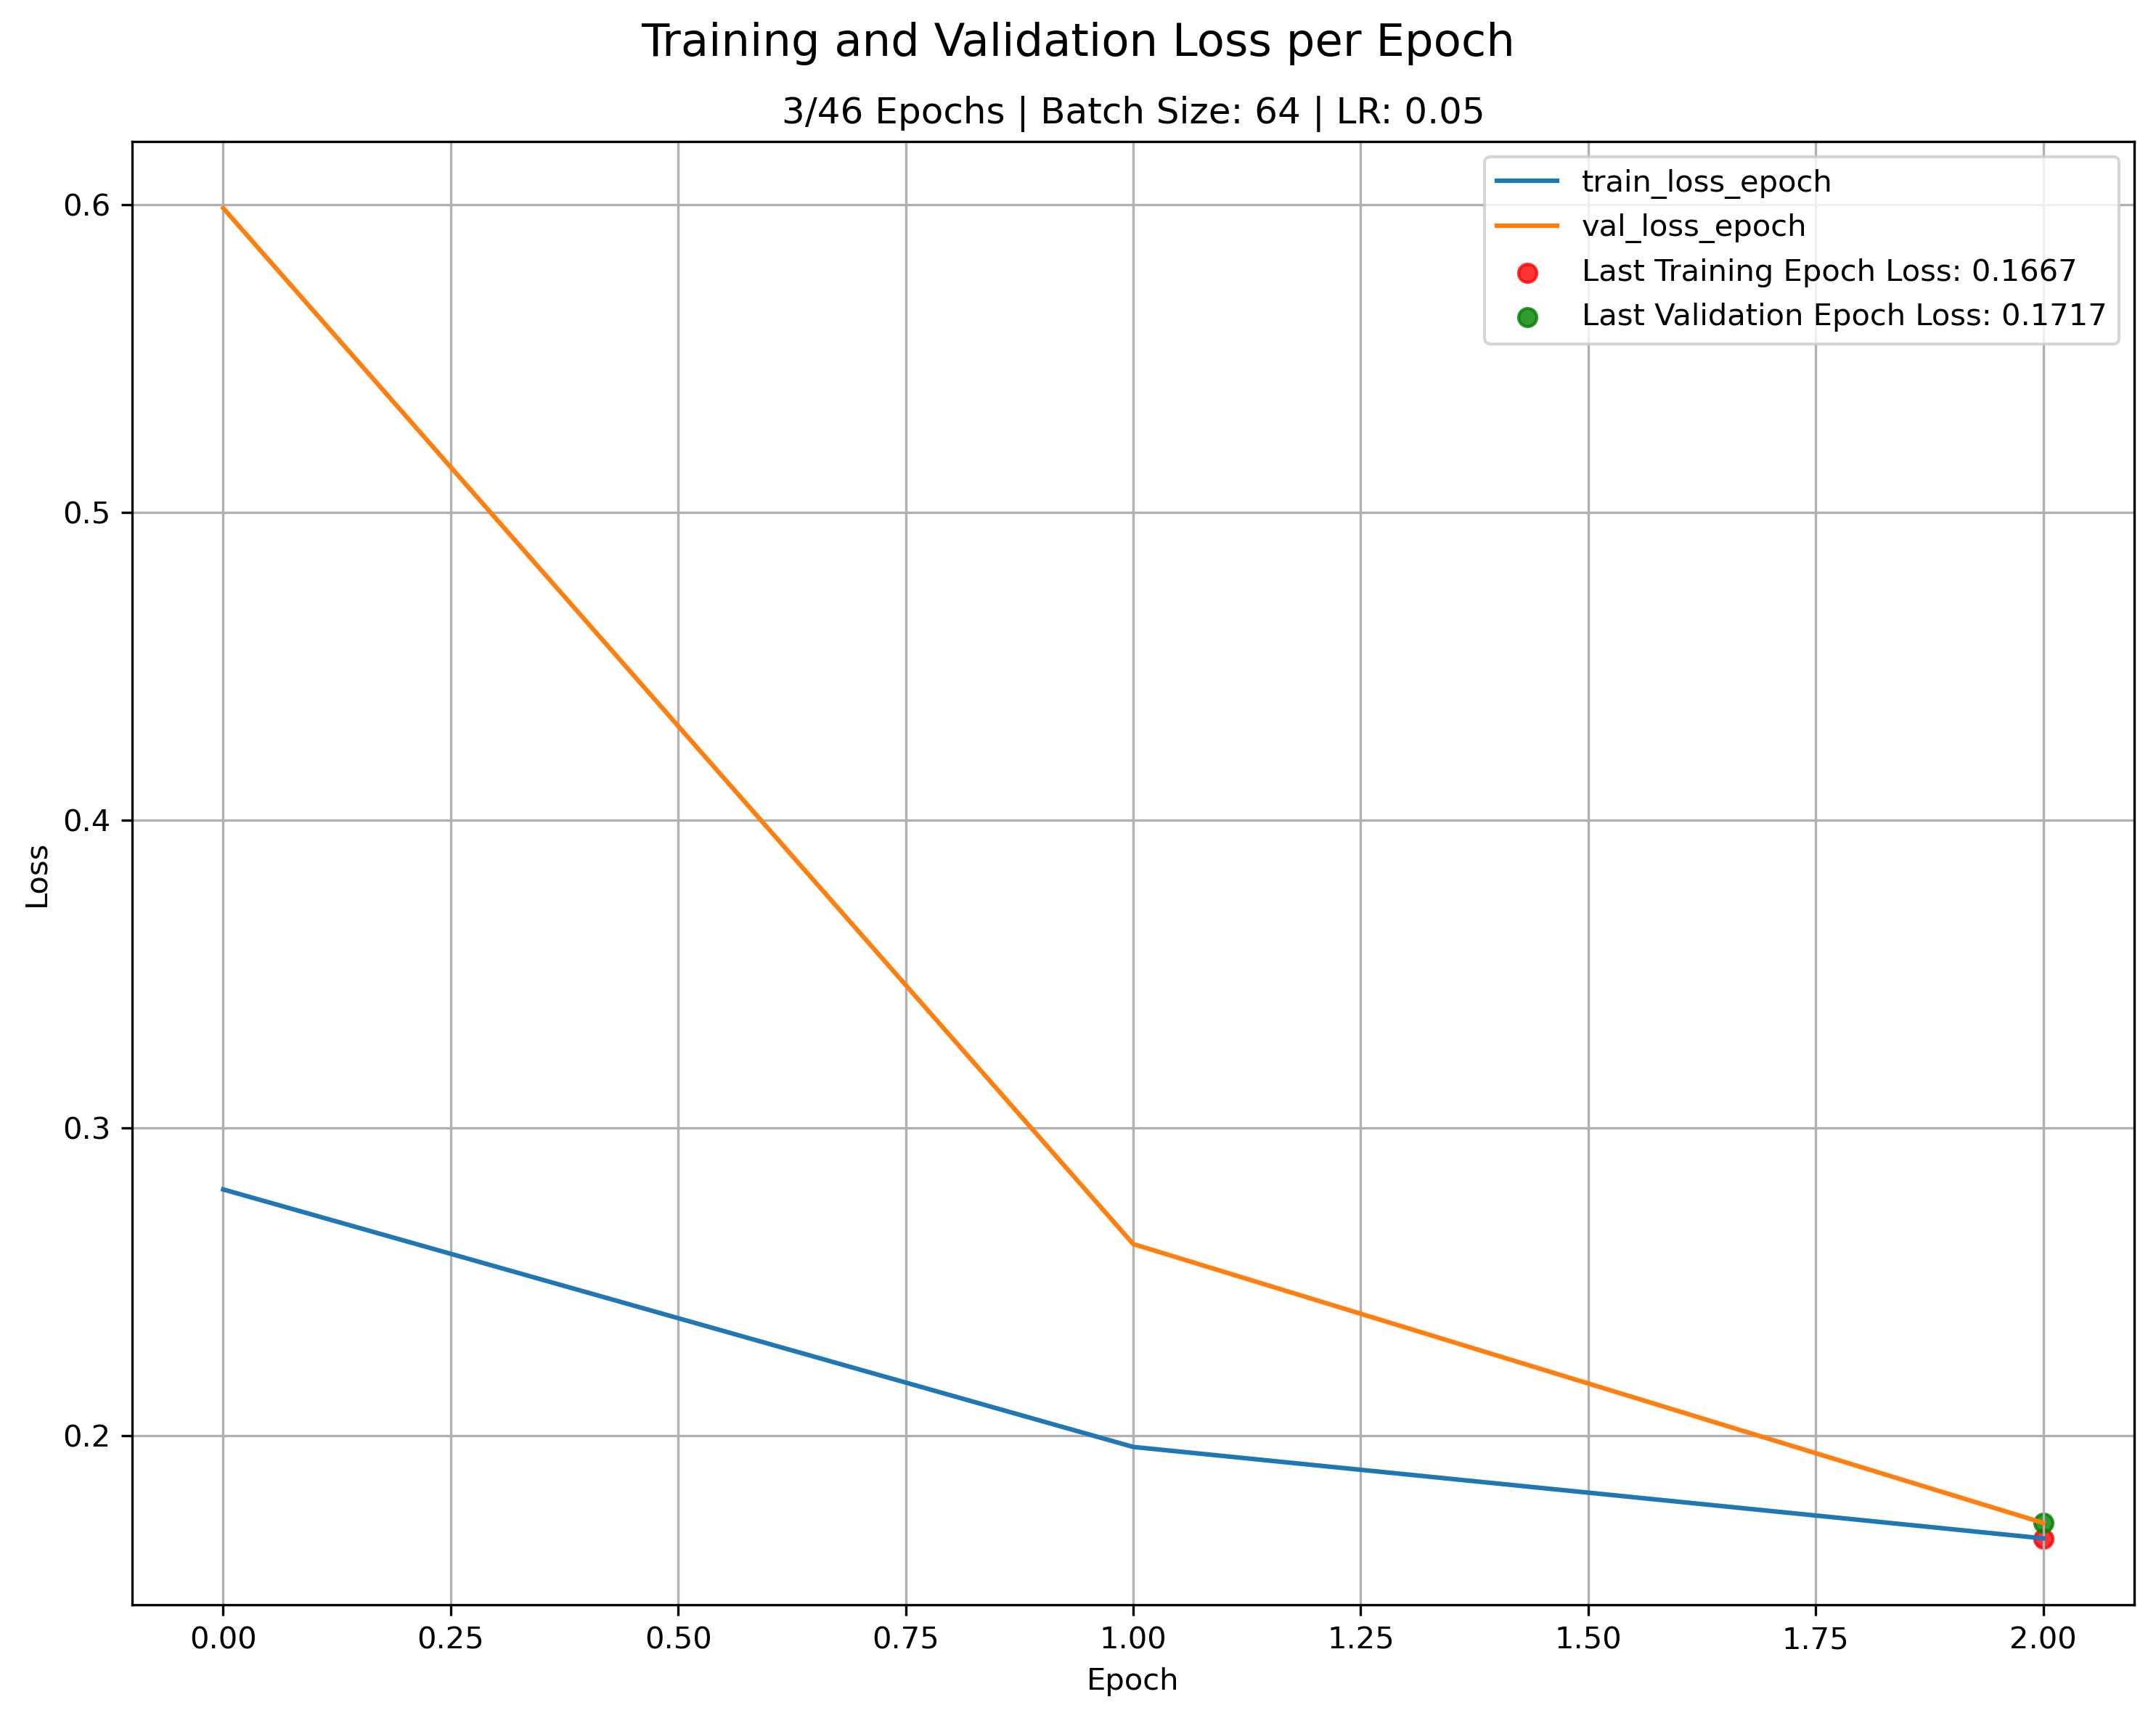

In [41]:
"""
RANDOM_SEED = 123
IMG_SIZE = 20
BATCH_SIZE = 64
TEST_SIZE = 0.2

NUM_EPOCHS = 47 #0.0465
LEARNING_RATE = 0.05
"""

plot_loss_and_acc(trainer.logger.log_dir)

# Evaluate


In [42]:
test_results = trainer.test(model=lightning_model, datamodule=datamodule)

length of dataloaders:
train_dataloader: (320) | val_dataloader: (80) | test_dataloader: (100)


/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/opt/miniconda3/envs/torch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.18811698257923126    │
└───────────────────────────┴───────────────────────────┘

# NaiveModel


              precision    recall  f1-score   support

    No Plane       0.51      1.00      0.67      3234
       Plane       0.00      0.00      0.00      3166

    accuracy                           0.51      6400
   macro avg       0.25      0.50      0.34      6400
weighted avg       0.26      0.51      0.34      6400



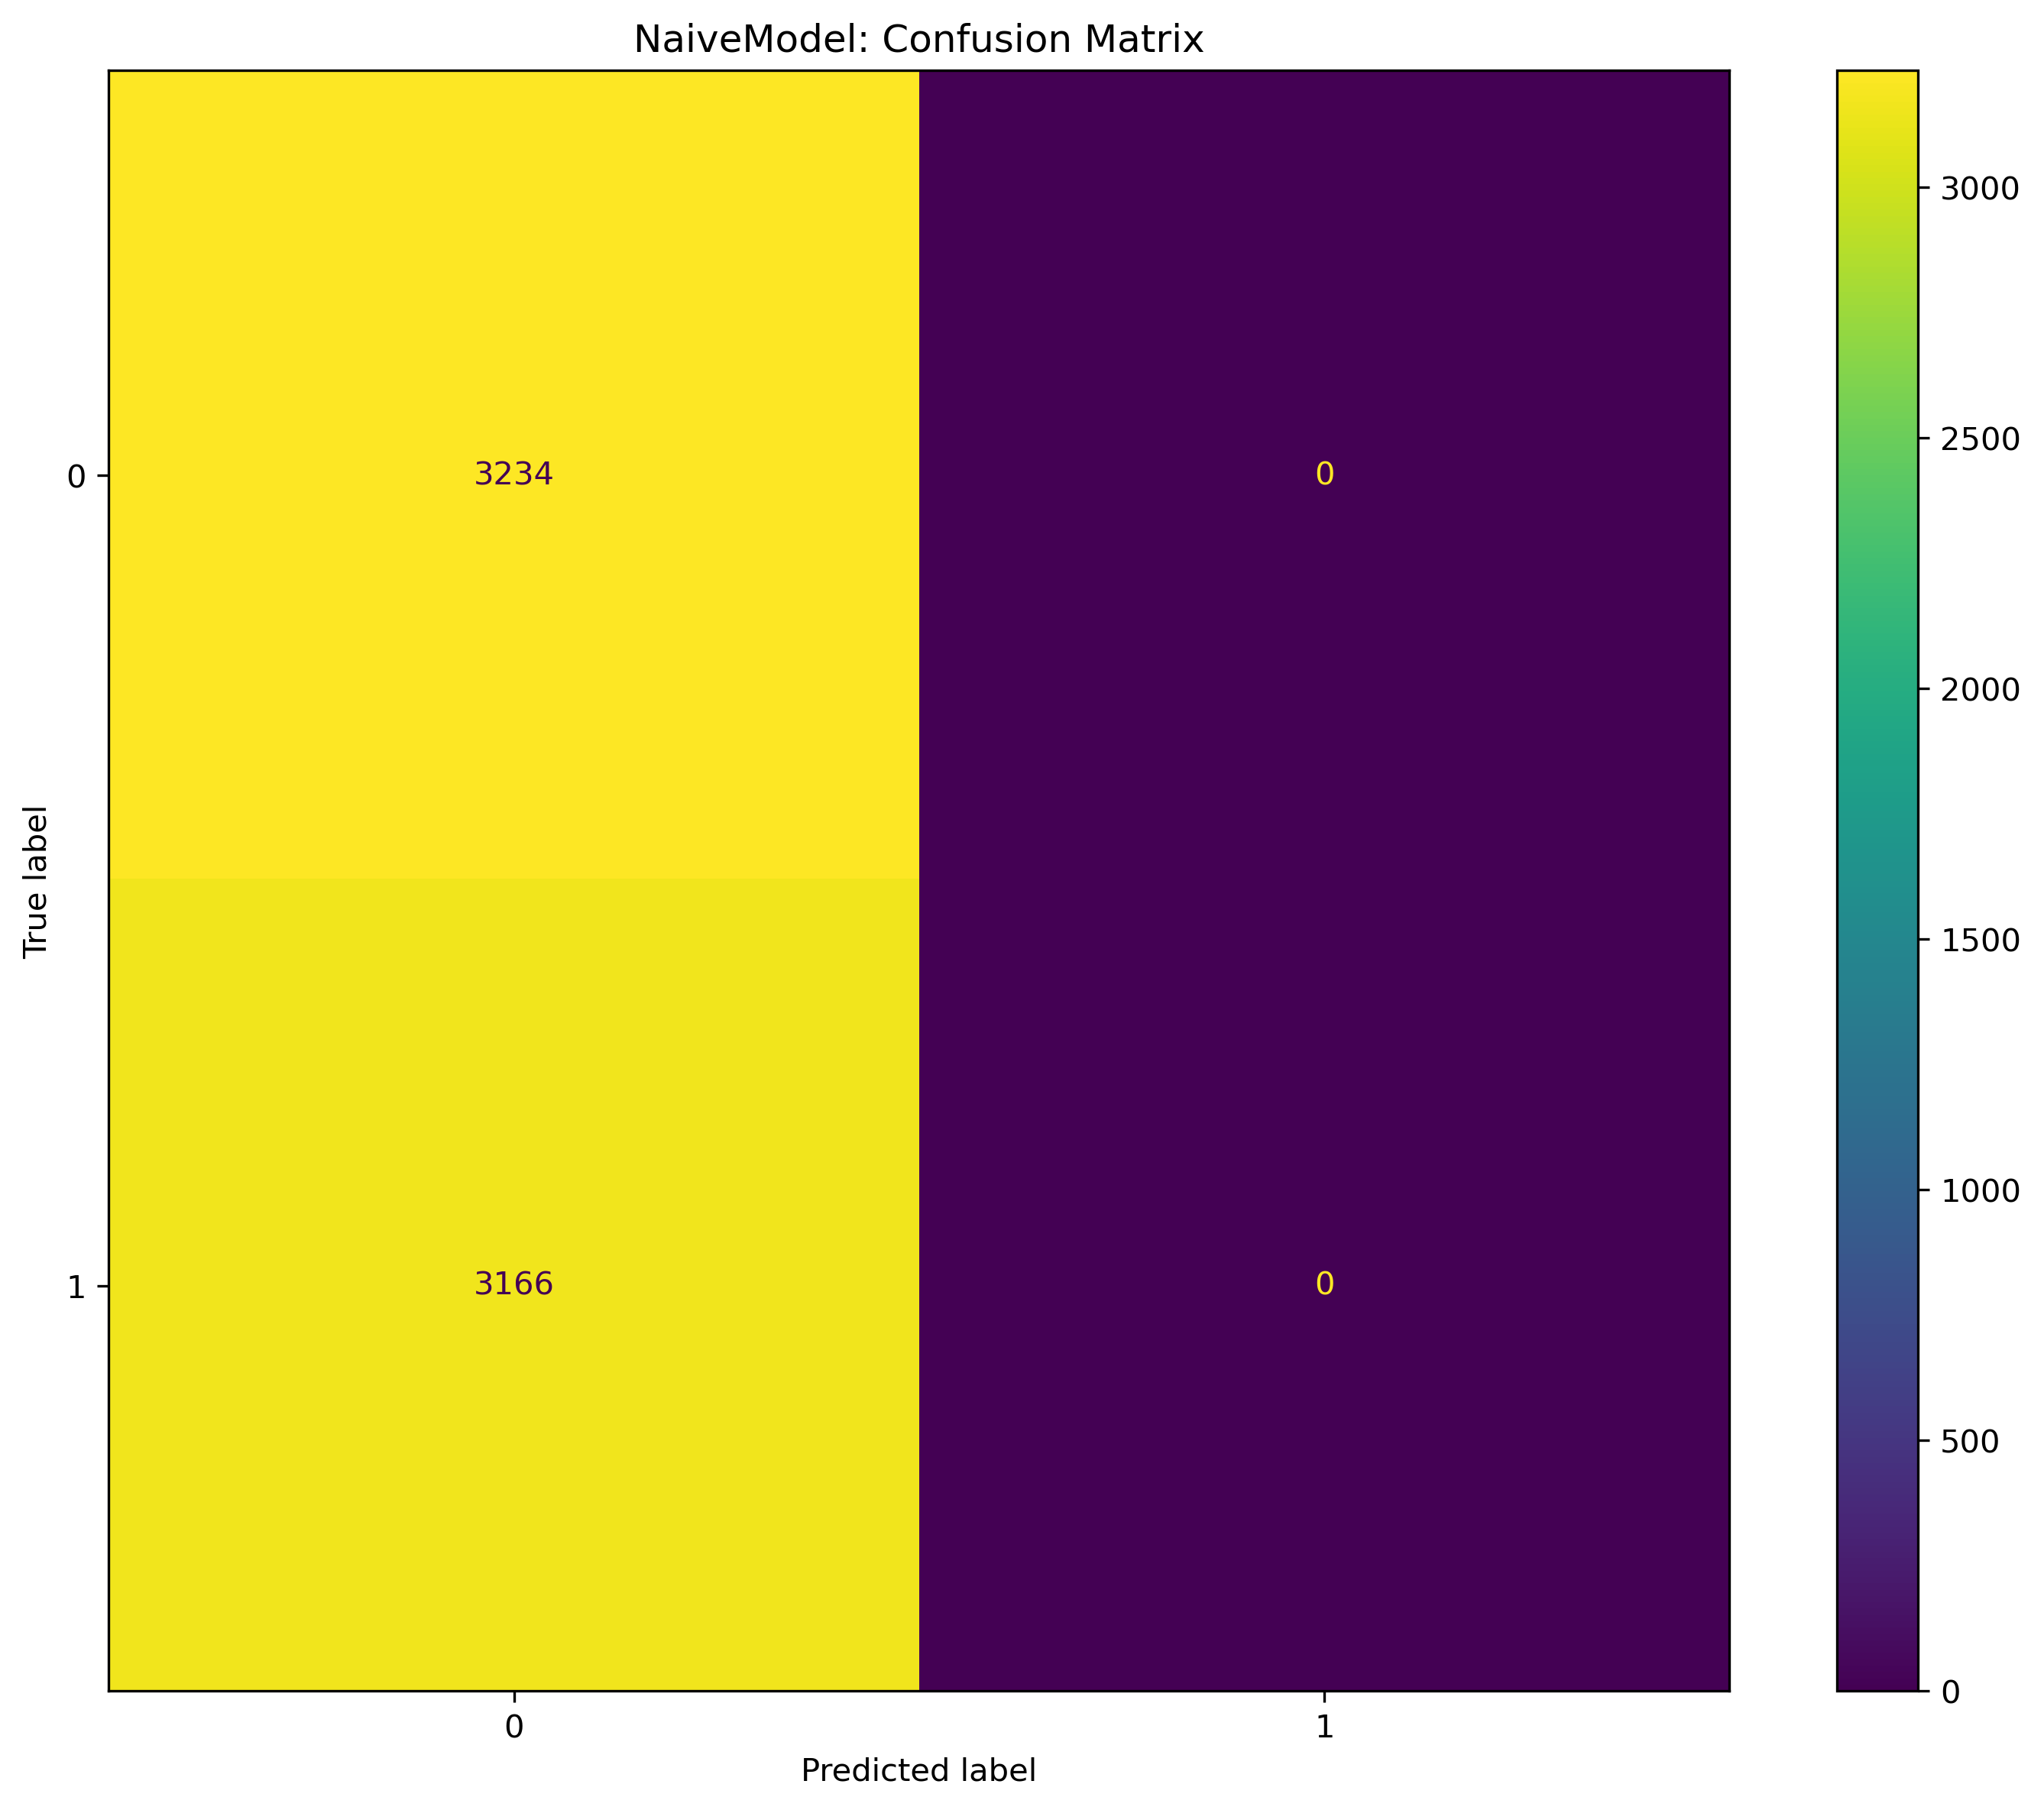

In [43]:
evaluate_naive_model(dataloader=datamodule.test_dataloader())

# Evaluate the trained-model


In [44]:
def evaluate_the_lightning_model(
    lightning_model: L.LightningModule,
    datamodule: L.LightningDataModule,
):

    lightning_model.eval()
    total_test_loss = 0
    test_loss_per_batch = []
    y_true_labels = []
    y_predictions = []

    model_name = lightning_model.model.__class__.__name__

    with torch.inference_mode():
        dataloader = datamodule.test_dataloader()
        for images, labels in dataloader:
            # images, labels = images.to(device), labels.to(device)
            test_logits = lightning_model(images)
            test_minibatch_loss = F.cross_entropy(
                test_logits, labels.type(torch.LongTensor)
            )
            test_loss_per_batch.append(test_minibatch_loss.item())
            total_test_loss += test_minibatch_loss.item()

            # Store labels and predictions for metric calculations
            y_true_labels.extend(labels.cpu().numpy())
            y_predictions.extend(test_logits.argmax(dim=1).cpu().numpy())

        avg_test_loss = total_test_loss / len(dataloader)
        print(f"Average test loss: {avg_test_loss:5f}\n")

        ### classification_report
        target_names = ["No Plane", "Plane"]

        report = classification_report(
            y_true=y_true_labels, y_pred=y_predictions, target_names=target_names
        )
        with open(
            f"classification_reports/{model_name}_classification_report.txt", "w"
        ) as f:
            f.write(report)

        print(report)

    return avg_test_loss, test_loss_per_batch, y_true_labels, y_predictions


avg_test_loss, test_loss_per_batch, y_true_labels, y_predictions = (
    evaluate_the_lightning_model(
        lightning_model=lightning_model,
        datamodule=datamodule,
    )
)

Average test loss: 0.188974

              precision    recall  f1-score   support

    No Plane       0.99      0.87      0.92      3250
       Plane       0.88      0.99      0.93      3150

    accuracy                           0.93      6400
   macro avg       0.93      0.93      0.93      6400
weighted avg       0.93      0.93      0.93      6400



In [45]:
correct_preds = []
incorrect_preds = []


type(y_true_labels)
print(y_true_labels[0] == y_predictions[0])

for i in range(len(y_true_labels)):
    if y_predictions[i] == y_true_labels[i]:
        correct_preds.append(i)
    else:
        incorrect_preds.append(i)

print(f"Correct predictions: {len(correct_preds)}")
print(f"Incorrect predictions: {len(incorrect_preds)}")
print(
    f"accuracy: {len(correct_preds)/(len(correct_preds) + len(incorrect_preds)) * 100:.2f}%"
)

True
Correct predictions: 5927
Incorrect predictions: 473
accuracy: 92.61%


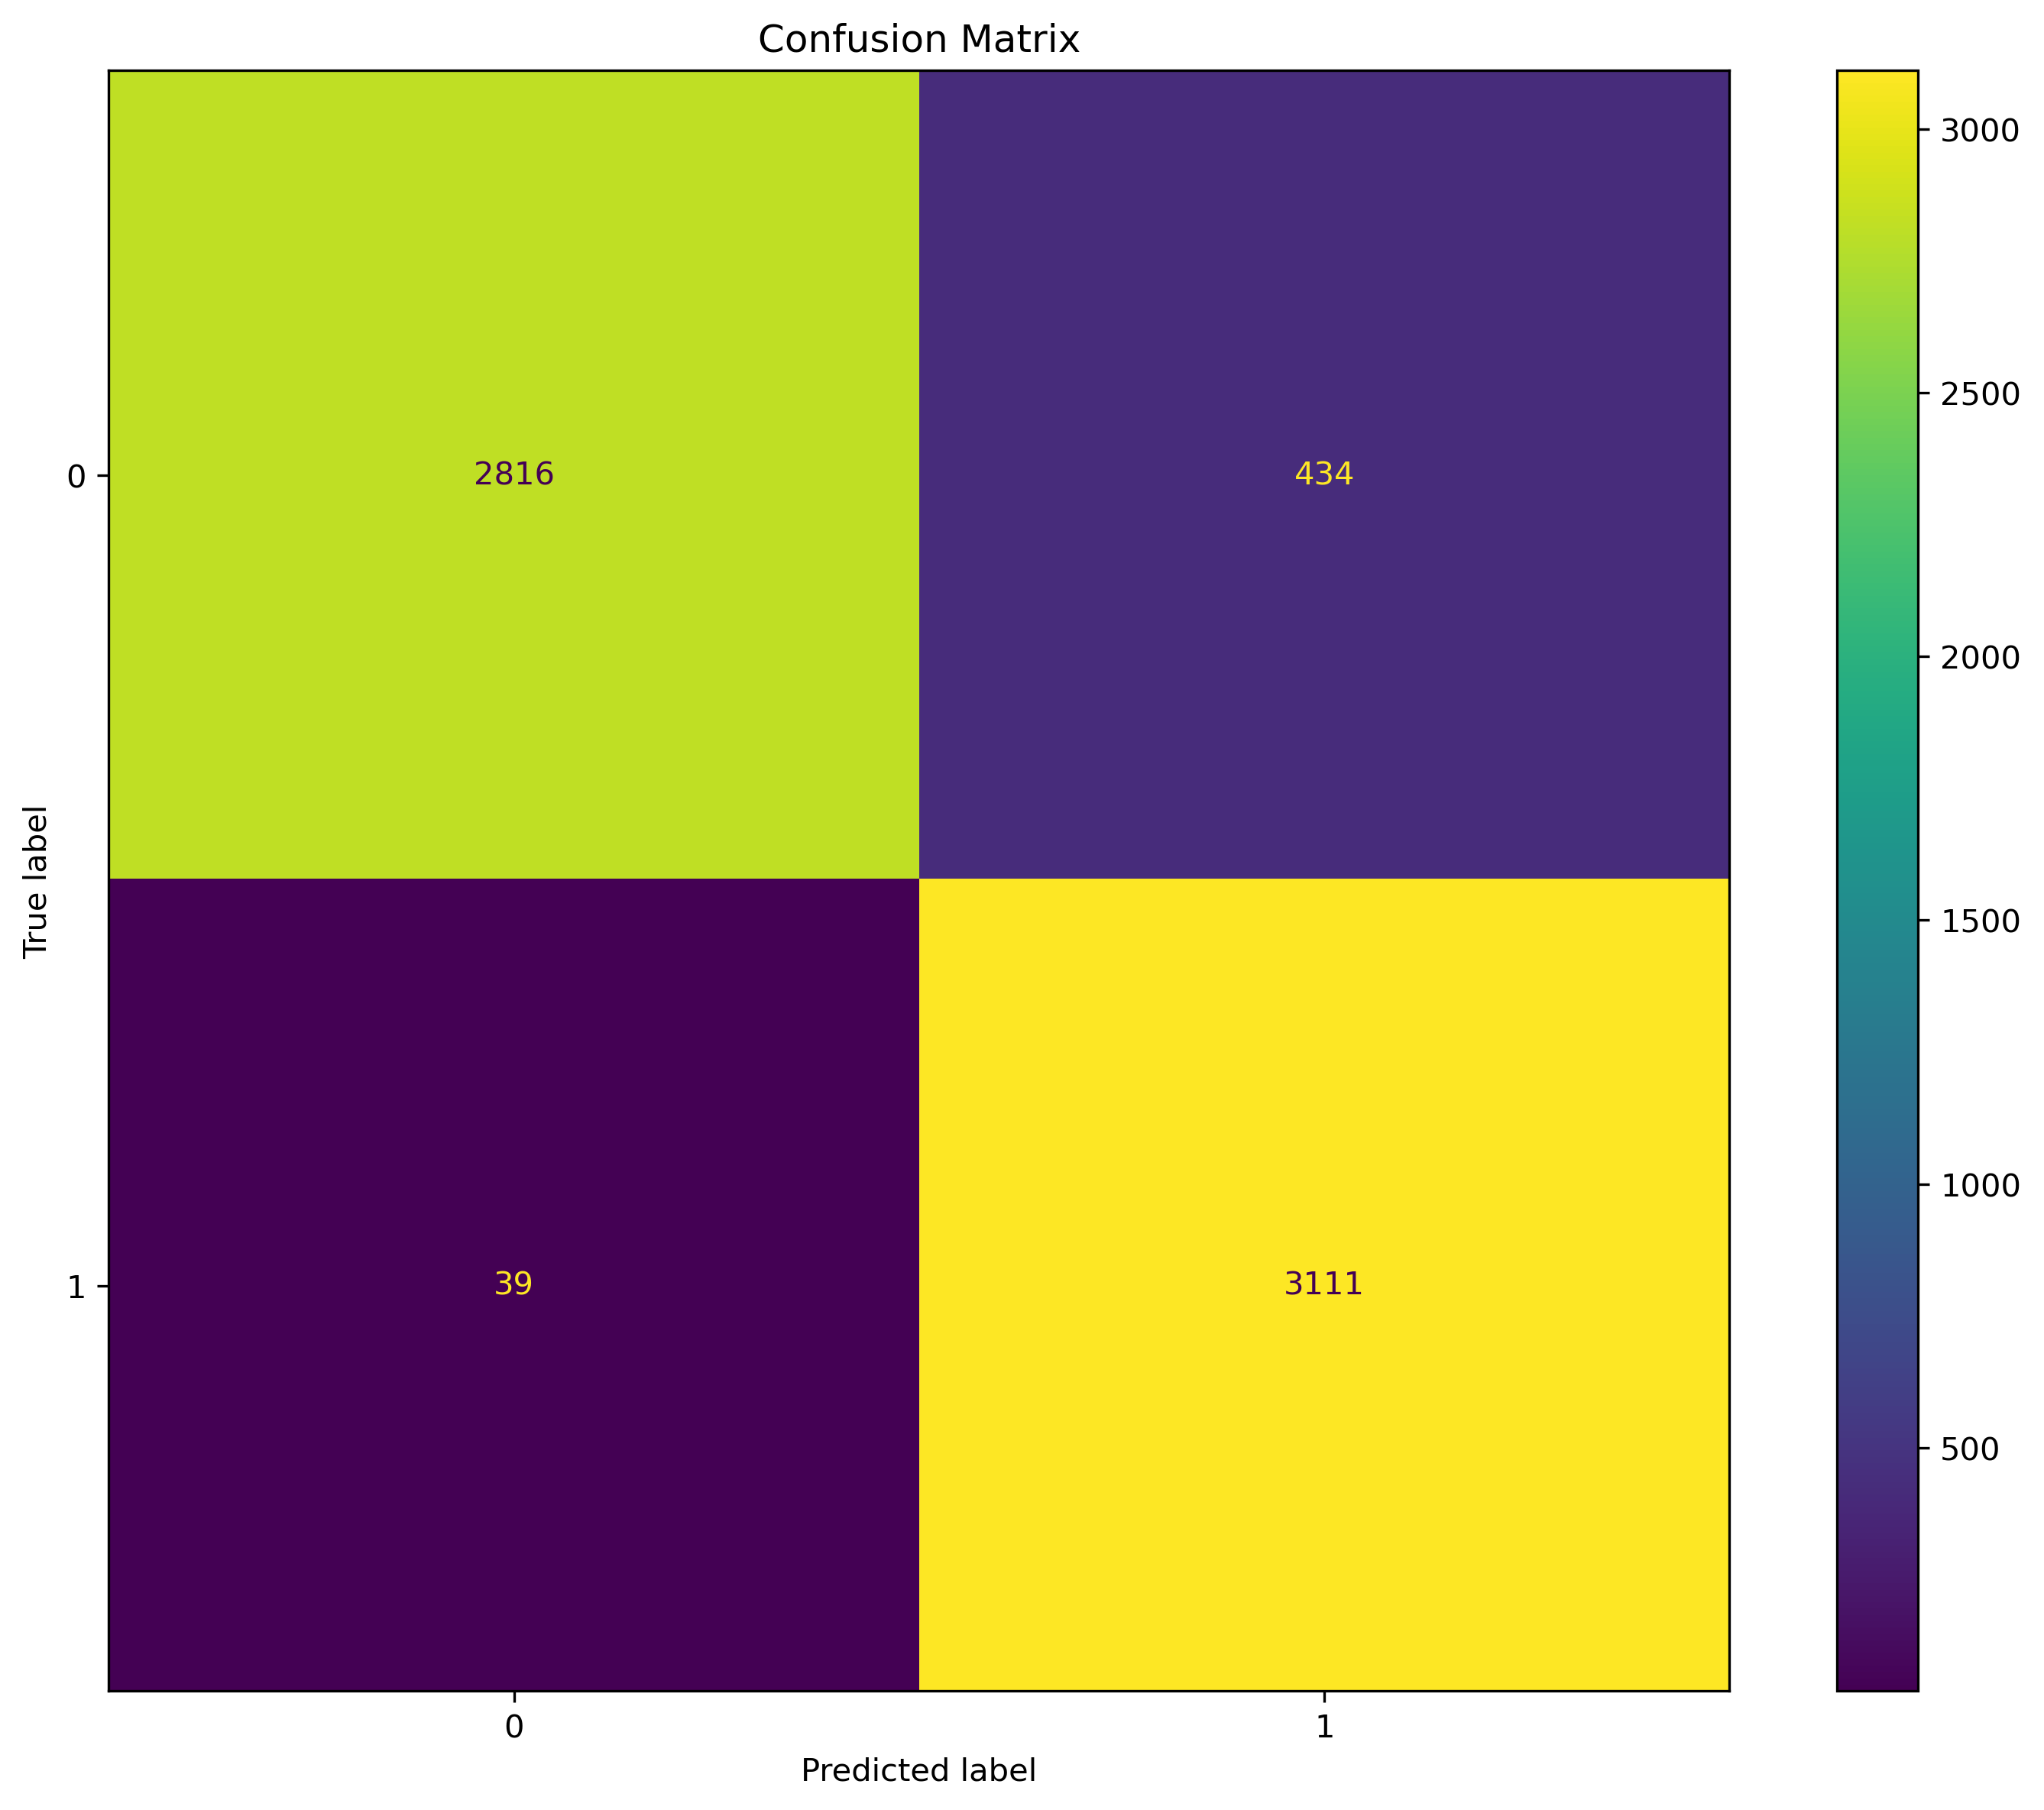

In [46]:
get_confusion_matrix(y_true=y_true_labels, y_pred=y_predictions)

# `plot_test_loss_per_batch()`


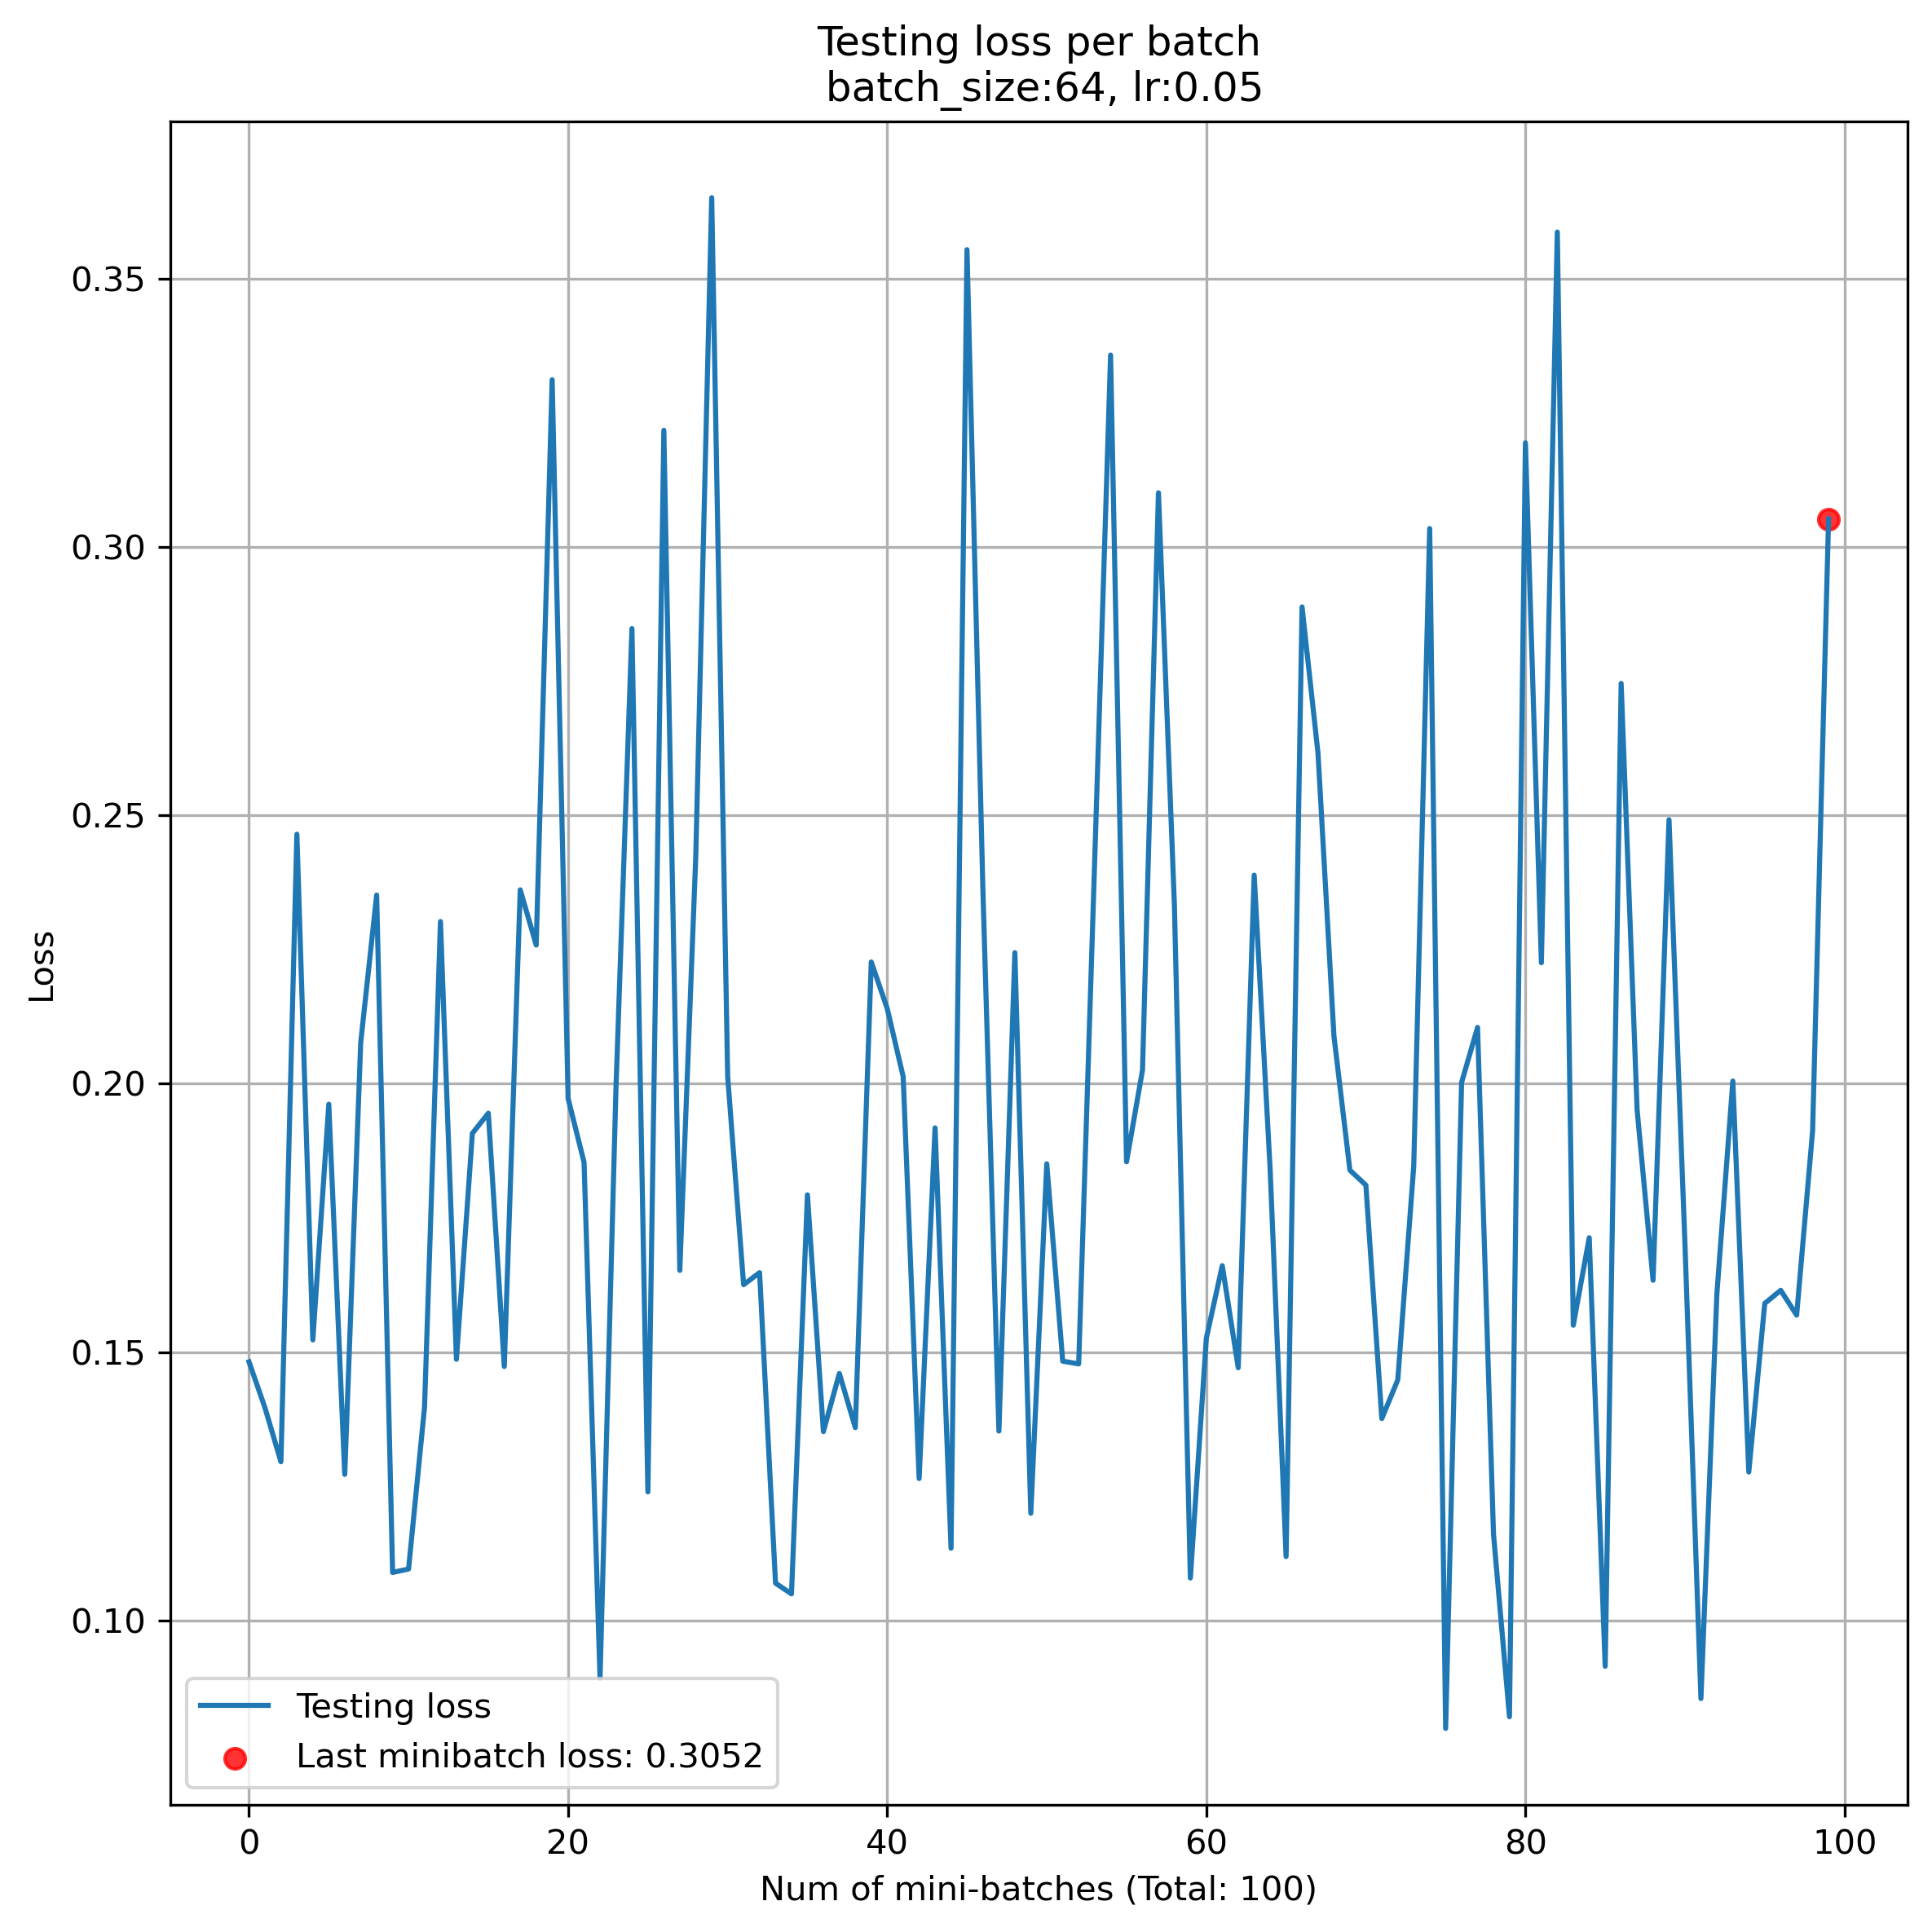

In [47]:
plot_test_loss_per_batch(
    test_loss_per_batch, batch_size=BATCH_SIZE, lr=LEARNING_RATE, num_epochs=NUM_EPOCHS
)

# Make Predictions and plot them


In [ ]:
def set_random_seed(seed_value=42):
    """Sets the random seed for reproducibility"""
    random.seed(seed_value)
    torch.manual_seed(seed_value)


def collect_samples_to_predict(
    datamodule: L.LightningDataModule, num_samples=36
) -> tuple[list, torch.Tensor]:
    """Collects a specified number of random samples and labels from the DataLoader.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader to collect samples from.
        num_samples (int, optional): The desired number of samples to collect. Defaults to 36.

    Returns:
        tuple[list, torch.Tensor]: A tuple containing a list of collected samples and a tensor of corresponding ground truth labels.
    """

    test_samples = []
    test_labels = []
    dataloader = datamodule.test_dataloader()

    for samples, labels in dataloader:
        # select 16  # change: maybe take 36 samples or more samples
        if len(test_samples) >= num_samples:
            break

        # generate a random index
        n = random.randint(0, samples.shape[0] - 1)
        test_samples.append(samples[n])  # 1 observation
        test_labels.append(labels[n])  # 1 observation

        ground_truth = torch.tensor(test_labels)

    return test_samples, ground_truth


def make_predictions(
    lightning_model: L.LightningModule, test_samples: list
) -> torch.Tensor:
    """Makes predictions on a list of samples using the model.

    Args:
        model (torch.nn.Module): The model to use for predictions.
        test_samples (list): A list of samples to make predictions on.
        device (torch.device): The device to use for computations (e.g., CPU or GPU).

    Returns:
        torch.Tensor: A tensor containing the predicted labels for the samples.
    """

    pred_labels_list = []

    lightning_model.eval()
    with torch.inference_mode():
        for sample in test_samples:
            pred_logits = lightning_model(sample.unsqueeze(dim=0))
            # y_probs = torch.softmax(y_logits, dim=1)
            pred_labels = torch.softmax(pred_logits, dim=1).argmax(dim=1)
            pred_labels_list.append(pred_labels.float().cpu())
            predictions = torch.stack(pred_labels_list)

    return predictions.squeeze()


def plotting(test_samples, predictions, ground_truth, model, normalized=True) -> None:
    """Creates a plot visualizing predictions vs. ground truth labels.

    Args:
        test_samples (list): A list of test samples (images).
        predictions (torch.Tensor): A tensor containing the predicted labels.
        ground_truth (torch.Tensor): A tensor containing the ground truth labels.
    """

    model_name = model.__class__.__name__

    plt.figure(figsize=(13, 13), dpi=300)

    nrows, ncols = 6, 6

    for i, sample in enumerate(test_samples):

        plt.subplot(nrows, ncols, i + 1)
        if normalized:  # default: True
            plt.imshow((sample).permute(1, 2, 0))
        else:
            plt.imshow((sample / 255.0).permute(1, 2, 0))

        pred_label = "Plane" if predictions[i] == 1.0 else "No Plane"
        truth_label = "Plane" if ground_truth[i] == 1.0 else "No Plane"

        if pred_label == truth_label:
            truth_label = "*Plane*" if truth_label == "Plane" else "No Plane"
            title_text = f"Pred: {pred_label} | Truth: {truth_label}"
            plt.title(title_text, fontsize=8, c="g")  # green text if correct
        else:
            truth_label = "*Plane*" if truth_label == "Plane" else "No Plane"
            title_text = f"Pred: {pred_label} | Truth: {truth_label}"
            plt.title(title_text, fontsize=8, c="r")  # red text if incorrect

        plt.axis("off")

    plt.suptitle("Predictions vs. Truths", fontsize=15)
    plt.tight_layout()
    plt.savefig(f"pred_vs_truth_plots/{model_name}.png", transparent=False, dpi=300)
    plt.show()


def plot_pred_vs_truth(
    datamodule: L.LightningDataModule,
    lightning_model: L.LightningModule,
    num_samples: int = 36,
    set_random: bool = True,
    normalized: bool = True,
):
    """Plots predictions vs. true labels"""

    if set_random:
        set_random_seed()

    test_samples, ground_truth = collect_samples_to_predict(
        datamodule, num_samples=num_samples
    )
    predictions = make_predictions(
        lightning_model=lightning_model, test_samples=test_samples
    )

    plotting(test_samples, predictions, ground_truth, lightning_model, normalized)

In [ ]:
# from my_helper_plotting import plot_pred_vs_truth

plot_pred_vs_truth(
    lightning_model=lightning_model,
    datamodule=datamodule,
    set_random=True,
    normalized=True,
)

# Save the modeL


In [ ]:
# save_model(
#     model=model_v1,
#     batch_size=BATCH_SIZE,
#     num_epochs=NUM_EPOCHS,
#     learning_rate=LEARNING_RATE,
# )

# GradCAM


In [ ]:
lightning_model.model.layers

In [ ]:
# randomly collect 10 plane and 10 no-plane images

file_folder = "planesnet/planesnet"

num_images = 6
list_of_planes = []
list_of_no_planes = []

list_of_files = os.listdir(file_folder)
shuffled_file_folder = random.sample(list_of_files, len(list_of_files))

for filename in shuffled_file_folder:

    if len(list_of_planes) < num_images and filename[0] == "1":
        list_of_planes.append(filename)

    if len(list_of_no_planes) <= num_images and filename[0] == "0":
        list_of_no_planes.append(filename)

list_of_planes

In [ ]:
### modify this


def plot_grad_cam_images(
    lightning_model: L.LightningModule,
    file_name: str,
    file_folder: str = "planesnet/planesnet",
) -> None:

    img_path = file_folder + "/" + file_name
    # Load and preprocess the image
    img = Image.open(img_path).convert("RGB")
    img = img.resize((20, 20))
    img = np.array(img)
    img_float_np = np.float32(img) / 255.0
    input_tensor = torch.from_numpy(img.transpose(2, 0, 1))
    input_tensor = input_tensor.type(torch.float32).unsqueeze(dim=0)

    # Model evaluation
    lightning_model.eval()
    with torch.inference_mode():
        outputs = lightning_model(input_tensor)
        y_pred_label = torch.argmax(outputs, dim=1)
    y_pred_label = y_pred_label.cpu().detach().item()

    # Grad-CAM setup
    target_layer = [lightning_model.model.layers[6]]
    cam = GradCAM(model=lightning_model, target_layers=target_layer)
    target_category = 1
    target_label = [ClassifierOutputTarget(target_category)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=target_label)
    grayscale_cam_ = grayscale_cam[0, :]
    cam_image = show_cam_on_image(img_float_np, grayscale_cam_, use_rgb=True)

    # Determine true and predicted labels
    y_true = "Plane" if file_name[0] == "1" else "No Plane"
    y_pred = "Plane" if y_pred_label == 1 else "No Plane"
    title_text = f"Prediction: {y_pred} | Truth: {y_true}"
    title_color = "g" if y_true == y_pred else "r"

    # Plotting
    fig = plt.figure(figsize=(8, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

    plt.suptitle(title_text, fontsize=15, c=title_color)

    # Grad-CAM overlay image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(cam_image)
    ax1.set_title(f"(Grad-CAM)")
    ax1.axis("on")

    # Original image
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(img)
    ax2.set_title(f"(Original)")
    ax2.axis("on")

    # Colorbar
    cbar_ax = fig.add_subplot(gs[0, 2])
    cmap = plt.cm.inferno
    norm = plt.Normalize(vmin=grayscale_cam.min(), vmax=grayscale_cam.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation="vertical")
    cbar.set_label("Activation Strength")

    # Display the plot
    plt.tight_layout()
    plt.show()


for filename in list_of_planes:
    plot_grad_cam_images(lightning_model=lightning_model, file_name=filename)

In [ ]:
for filename in list_of_no_planes:
    plot_grad_cam_images(lightning_model=lightning_model, file_name=filename)

# Identify planes on scene


In [ ]:
def make_predictions_on_scene(lighting_model: L.LightningModule, img_boxes: np.ndarray):
    input_transposed = img_boxes.transpose(0, 3, 1, 2)
    input_tensor = torch.from_numpy(input_transposed).type(torch.float32)
    output_logits = lighting_model(input_tensor)
    predictions = torch.argmax(output_logits, dim=1)
    return predictions.cpu().numpy()


def process_scene(image_name, lightning_model, stride=5, img_folder="scenes/scenes"):
    img_input_size = 20
    image_path = os.path.join(img_folder, image_name)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(1, 1, 1)
    ax.imshow(img)

    patches_list = []
    coords_list = []

    for h in range(0, height - img_input_size, stride):
        for w in range(0, width - img_input_size, stride):
            img_box = img[h : h + img_input_size, w : w + img_input_size]
            patches_list.append(img_box)
            coords_list.append((w, h))

    img_boxes = np.array(patches_list)
    predictions = make_predictions_on_scene(lightning_model, img_boxes)

    for (w, h), prediction in zip(coords_list, predictions):
        if prediction == 1:
            ax.add_patch(
                matplotlib.patches.Rectangle(
                    (w, h),
                    img_input_size,
                    img_input_size,
                    edgecolor="r",
                    facecolor="none",
                )
            )

    plt.savefig(f"predict_from_scene_plots/predicted_{image_name}.png", dpi=300)
    plt.show()

In [ ]:
# Usage
img_path = "scene_2.png"
process_scene(img_path, lightning_model, stride=4)

In [ ]:
# scenes_folder = "scenes/scenes"
# for img_name in os.listdir(scenes_folder):

#     process_scene(img_name, lightning_model, stride=5)

# Testing with images from other dataset


In [ ]:
os.listdir("scenes/extras")

scenes_folder = "scenes/extras"
for img_name in os.listdir(scenes_folder):

    process_scene(img_name, lightning_model, stride=5, img_folder=scenes_folder)

# process_scene(img_name, model_v1, stride=5, img_input_size=20)

# Transfer Learning


### function to train and evaluate pretrained models


In [ ]:
print(watermark(packages="torch, lightning", python=True))
print(device)
RANDOM_SEED = 123
INPUT_SIZE = 20
BATCH_SIZE = 64
TEST_SIZE = 0.2

NUM_EPOCHS = 47
LEARNING_RATE = 0.05
DEVICE = device

L.seed_everything(RANDOM_SEED)

datamodule = PlanesLightningDataModule(
    dataframe=image_data,
    normalized=True,  # [0, 1]
    apply_aug=True,
    batch_size=BATCH_SIZE,
    data_transforms=None,
    test_size=TEST_SIZE,
)

In [ ]:
def train_and_evaluate_pretrained(
    pytorch_model: torch.nn.Module,
    datamodule: L.LightningDataModule,
    learning_rate=LEARNING_RATE,
    input_size=INPUT_SIZE,
    num_epochs=NUM_EPOCHS,
):

    model_name = pytorch_model.__class__.__name__
    ### train
    lightning_model = PlanesLightningModule(
        pytorch_model, learning_rate=learning_rate, input_size=input_size
    )

    callbacks = [
        TQDMProgressBar(refresh_rate=20),
        ModelSummary(max_depth=3),
        # RichProgressBar(leave=True),
        # EarlyStopping(monitor="val_loss", mode="min", patience=5),
    ]

    trainer = L.Trainer(
        # fast_dev_run=2,
        max_epochs=num_epochs,
        accelerator="mps",
        devices="auto",
        logger=CSVLogger(save_dir="logs", name=f"my_lightning_{model_name}"),
        precision="16-mixed",
        callbacks=callbacks,
    )

    trainer.fit(
        model=lightning_model,
        # train_dataloaders=None,
        # val_dataloaders=None,
        datamodule=datamodule,
    )

    ### training results
    plot_loss_and_acc(trainer.logger.log_dir)

    ### evaluate
    avg_test_loss, test_loss_per_batch, y_true_labels, y_predictions = (
        evaluate_the_lightning_model(
            lightning_model=lightning_model,
            datamodule=datamodule,
        )
    )
    ### confusion_matrix
    get_confusion_matrix(y_true=y_true_labels, y_pred=y_predictions)

    ### plot test loss per batch
    plot_test_loss_per_batch(
        test_loss_per_batch,
        batch_size=BATCH_SIZE,
        lr=LEARNING_RATE,
        num_epochs=NUM_EPOCHS,
    )

    ### plot pred vs truth
    plot_pred_vs_truth(
        lightning_model=lightning_model,
        datamodule=datamodule,
        set_random=True,
        normalized=True,
    )


### usage
# train_and_evaluate_pretrained(
#     pytorch_model=pytorch_model,
#     datamodule=datamodule,
#     learning_rate=LEARNING_RATE,
#     input_size=INPUT_SIZE,
#     num_epochs=NUM_EPOCHS,
# )

## 1. Resnet18


### model info


In [ ]:
from torchinfo import summary

resnet18_pytorch = torch.hub.load(
    "pytorch/vision", "resnet18", weights="ResNet18_Weights.DEFAULT"
)

for param in resnet18_pytorch.parameters():
    param.requires_grad = False

summary(resnet18_pytorch, input_size=[1, 3, 20, 20])

### custom classifier


In [ ]:
in_features = resnet18_pytorch.fc.in_features
resnet18_pytorch.fc = nn.Linear(in_features, out_features=2)

summary(resnet18_pytorch, input_size=[1, 3, 20, 20])

### training


In [ ]:
## usage
train_and_evaluate_pretrained(
    pytorch_model=resnet18_pytorch,
    datamodule=datamodule,
    learning_rate=LEARNING_RATE,
    input_size=INPUT_SIZE,
    num_epochs=NUM_EPOCHS,
)

### training results


In [ ]:
# plot_loss_and_acc(trainer.logger.log_dir)

### evaluate


In [ ]:
avg_test_loss, test_loss_per_batch, y_true_labels, y_predictions = (
    evaluate_the_lightning_model(
        lightning_model=lightning_model,
        datamodule=datamodule,
    )
)

In [ ]:
# correct_preds = []
# incorrect_preds = []


# type(y_true_labels)
# print(y_true_labels[0] == y_predictions[0])

# for i in range(len(y_true_labels)):
#     if y_predictions[i] == y_true_labels[i]:
#         correct_preds.append(i)
#     else:
#         incorrect_preds.append(i)

# print(f"Correct predictions: {len(correct_preds)}")
# print(f"Incorrect predictions: {len(incorrect_preds)}")
# print(
#     f"accuracy: {len(correct_preds)/(len(correct_preds) + len(incorrect_preds)) * 100:.2f}%"
# )

In [ ]:
# get_confusion_matrix(y_true=y_true_labels, y_pred=y_predictions)

In [ ]:
# plot_test_loss_per_batch(
#     test_loss_per_batch, batch_size=BATCH_SIZE, lr=LEARNING_RATE, num_epochs=NUM_EPOCHS
# )

In [ ]:
# plot_pred_vs_truth(
#     lightning_model=lightning_model,
#     datamodule=datamodule,
#     set_random=True,
#     normalized=True,
# )

## 2. resnet50


### model info


In [ ]:
resnet50_model = torch.hub.load(
    "pytorch/vision", "resnet50", weights="ResNet50_Weights.IMAGENET1K_V1"
)

for param in resnet50_model.parameters():
    param.requires_grad = False

summary(resnet50_model, input_size=[1, 3, 20, 20])

### custom classifier


In [ ]:
in_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(in_features, out_features=2)

summary(resnet50_model, input_size=[1, 3, 20, 20])

### training


In [ ]:
## usage
train_and_evaluate_pretrained(
    pytorch_model=resnet50_model,
    datamodule=datamodule,
    learning_rate=LEARNING_RATE,
    input_size=INPUT_SIZE,
    num_epochs=NUM_EPOCHS,
)

# print(watermark(packages="torch, lightning", python=True))
# print(device)

# RANDOM_SEED = 123
# INPUT_SIZE = 20
# BATCH_SIZE = 64
# TEST_SIZE = 0.2

# NUM_EPOCHS = 20
# LEARNING_RATE = 0.05

# L.seed_everything(RANDOM_SEED)

# datamodule = PlanesLightningDataModule(
#     dataframe=image_data,
#     normalized=True,  # [0, 1]
#     apply_aug=True,
#     batch_size=BATCH_SIZE,
#     data_transforms=None,
#     test_size=TEST_SIZE,
# )


# lightning_model = PlanesLightningModule(
#     resnet50_model, learning_rate=LEARNING_RATE, input_size=INPUT_SIZE
# )  # lr is key

# callbacks = [
#     TQDMProgressBar(refresh_rate=20),
#     ModelSummary(max_depth=3),
#     # RichProgressBar(leave=True),
#     EarlyStopping(monitor="val_loss", mode="min", patience=5),
# ]

# trainer = L.Trainer(
#     # fast_dev_run=2,
#     max_epochs=NUM_EPOCHS,
#     accelerator="mps",
#     devices="auto",
#     logger=CSVLogger(save_dir="logs", name="my_lightning_model"),
#     precision="16-mixed",
#     callbacks=callbacks,
# )

# train_time_start = timer()
# trainer.fit(
#     model=lightning_model,
#     # train_dataloaders=None,
#     # val_dataloaders=None,
#     datamodule=datamodule,
# )
# train_time_end = timer()
# total_train_time_model_0 = print_train_time(
#     start=train_time_start,
#     end=train_time_end,
#     device=device,
# )

### training results


In [ ]:
# plot_loss_and_acc(trainer.logger.log_dir)

### evaluate


In [ ]:
# avg_test_loss, test_loss_per_batch, y_true_labels, y_predictions = (
#     evaluate_the_lightning_model(
#         lightning_model=lightning_model,
#         datamodule=datamodule,
#     )
# )

In [ ]:
# correct_preds = []
# incorrect_preds = []


# type(y_true_labels)
# print(y_true_labels[0] == y_predictions[0])

# for i in range(len(y_true_labels)):
#     if y_predictions[i] == y_true_labels[i]:
#         correct_preds.append(i)
#     else:
#         incorrect_preds.append(i)

# print(f"Correct predictions: {len(correct_preds)}")
# print(f"Incorrect predictions: {len(incorrect_preds)}")
# print(
#     f"accuracy: {len(correct_preds)/(len(correct_preds) + len(incorrect_preds)) * 100:.2f}%"
# )

In [ ]:
# get_confusion_matrix(y_true=y_true_labels, y_pred=y_predictions)

In [ ]:
# plot_test_loss_per_batch(
#     test_loss_per_batch, batch_size=BATCH_SIZE, lr=LEARNING_RATE, num_epochs=NUM_EPOCHS
# )

In [ ]:
# plot_pred_vs_truth(
#     lightning_model=lightning_model,
#     datamodule=datamodule,
#     set_random=True,
#     normalized=True,
# )

## EfficientNetV2-S


In [ ]:
efficientnet_v2_s = torchvision.models.efficientnet_v2_s(weights="IMAGENET1K_V1")

### model info


In [ ]:
summary(
    model=efficientnet_v2_s,
    input_size=(1, 3, 20, 20),  # make sure this is "input_size", not "input_shape"
    # col_names=["input_size"], # uncomment for smaller output
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

In [ ]:
efficientnet_v2_s = torchvision.models.efficientnet_v2_s(weights="IMAGENET1K_V1")

for param in efficientnet_v2_s.features.parameters():
    param.requires_grad = False

### custom classifier


In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Recreate the classifier layer and seed it to the target device
efficientnet_v2_s.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=1280,
        out_features=2,  # same number of output units as our number of classes
        bias=True,
    ),
).to(device)


summary(
    efficientnet_v2_s,
    input_size=(1, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

### training


In [ ]:
print(watermark(packages="torch, lightning", python=True))
print(device)

RANDOM_SEED = 123
INPUT_SIZE = 20
BATCH_SIZE = 64
TEST_SIZE = 0.2

NUM_EPOCHS = 47
LEARNING_RATE = 0.05

L.seed_everything(RANDOM_SEED)

datamodule = PlanesLightningDataModule(
    dataframe=image_data,
    normalized=True,  # [0, 1]
    apply_aug=True,
    batch_size=BATCH_SIZE,
    data_transforms=None,
    test_size=TEST_SIZE,
)

train_and_evaluate_pretrained(
    pytorch_model=efficientnet_v2_s,
    datamodule=datamodule,
    learning_rate=LEARNING_RATE,
    input_size=INPUT_SIZE,
    num_epochs=NUM_EPOCHS,
)


# lightning_model = PlanesLightningModule(
#     efficientnet_v2_s, learning_rate=LEARNING_RATE, input_size=INPUT_SIZE
# )  # lr is key

# callbacks = [
#     TQDMProgressBar(refresh_rate=20),
#     ModelSummary(max_depth=3),
#     # RichProgressBar(leave=True),
#     EarlyStopping(monitor="val_loss", mode="min", patience=5),
# ]

# trainer = L.Trainer(
#     # fast_dev_run=2,
#     max_epochs=NUM_EPOCHS,
#     accelerator="mps",
#     devices="auto",
#     logger=CSVLogger(save_dir="logs", name="my_lightning_model"),
#     precision="16-mixed",
#     callbacks=callbacks,
# )

# train_time_start = timer()
# trainer.fit(
#     model=lightning_model,
#     # train_dataloaders=None,
#     # val_dataloaders=None,
#     datamodule=datamodule,
# )
# train_time_end = timer()
# total_train_time_model_0 = print_train_time(
#     start=train_time_start,
#     end=train_time_end,
#     device=device,
# )

### training results


In [ ]:
# plot_loss_and_acc(trainer.logger.log_dir)

### evaluate


In [ ]:
# avg_test_loss, test_loss_per_batch, y_true_labels, y_predictions = (
#     evaluate_the_lightning_model(
#         lightning_model=lightning_model,
#         datamodule=datamodule,
#     )
# )

In [ ]:
# correct_preds = []
# incorrect_preds = []


# type(y_true_labels)
# print(y_true_labels[0] == y_predictions[0])

# for i in range(len(y_true_labels)):
#     if y_predictions[i] == y_true_labels[i]:
#         correct_preds.append(i)
#     else:
#         incorrect_preds.append(i)

# print(f"Correct predictions: {len(correct_preds)}")
# print(f"Incorrect predictions: {len(incorrect_preds)}")
# print(
#     f"accuracy: {len(correct_preds)/(len(correct_preds) + len(incorrect_preds)) * 100:.2f}%"
# )

In [ ]:
# get_confusion_matrix(y_true=y_true_labels, y_pred=y_predictions)

In [ ]:
# plot_test_loss_per_batch(
#     test_loss_per_batch, batch_size=BATCH_SIZE, lr=LEARNING_RATE, num_epochs=NUM_EPOCHS
# )

In [ ]:
# plot_pred_vs_truth(
#     lightning_model=lightning_model,
#     datamodule=datamodule,
#     set_random=True,
#     normalized=True,
# )

## mobilenet_v2


In [ ]:
mobilenet_v2 = torchvision.models.mobilenet_v2(weights="IMAGENET1K_V1")

for param in mobilenet_v2.features.parameters():
    param.requires_grad = False


summary(
    model=mobilenet_v2,
    input_size=(1, 3, 20, 20),  # make sure this is "input_size", not "input_shape"
    # col_names=["input_size"], # uncomment for smaller output
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

In [ ]:
for param in mobilenet_v2.features.parameters():
    param.requires_grad = False


# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate the classifier layer and seed it to the target device
mobilenet_v2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=1280,
        out_features=2,  # same number of output units as our number of classes
        bias=True,
    ),
).to(device)

summary(
    mobilenet_v2,
    input_size=(1, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

In [ ]:
train_and_evaluate_pretrained(
    pytorch_model=mobilenet_v2,
    datamodule=datamodule,
    learning_rate=LEARNING_RATE,
    input_size=INPUT_SIZE,
    num_epochs=NUM_EPOCHS,
)

## [NO] densenet121


In [ ]:
# densenet121 = torchvision.models.densenet121(weights="IMAGENET1K_V1")

In [ ]:
# densenet121 = torchvision.models.densenet121(weights="IMAGENET1K_V1")

# for param in densenet121.features.parameters():
#     param.requires_grad = False


# # Set the manual seeds
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# # Recreate the classifier layer and seed it to the target device
# densenet121.classifier = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.2, inplace=True),
#     torch.nn.Linear(
#         in_features=1280,
#         out_features=2,  # same number of output units as our number of classes
#         bias=True,
#     ),
# ).to(device)

In [ ]:
# train_and_evaluate_pretrained(
#     pytorch_model=densenet121,
#     datamodule=datamodule,
#     learning_rate=LEARNING_RATE,
#     input_size=INPUT_SIZE,
#     num_epochs=NUM_EPOCHS,
# )

## [NO] vit_b_16


In [ ]:
# vit_b_16 = torchvision.models.vit_b_16(weights="IMAGENET1K_V1")

# for param in vit_b_16.encoder.parameters():
#     param.requires_grad = False

# for param in vit_b_16.conv_proj.parameters():
#     param.requires_grad = False

# # Set the manual seeds
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# # Recreate the classifier layer and seed it to the target device
# vit_b_16.heads = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.2, inplace=True),
#     torch.nn.Linear(
#         in_features=768,
#         out_features=2,  # same number of output units as our number of classes
#         bias=True,
#     ),
# ).to(device)

# # train_and_evaluate_pretrained(
# #     pytorch_model=vit_b_16,
# #     datamodule=datamodule,
# #     learning_rate=LEARNING_RATE,
# #     input_size=INPUT_SIZE,
# #     num_epochs=NUM_EPOCHS,
# # )